<a href="https://colab.research.google.com/github/TalhaOmi/-bengali-fake-news-using-bangla-bert-base/blob/main/(Main)_bengali_fake_news_using_bangla_bert_base_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**NLP**

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import warnings
warnings.filterwarnings('ignore')

### Train and Test split: 
(only 20% data used for testing)
- Total Dataset size: 10392
- Total train size: 8313
- Test train size: 2079

In [ ]:
!pip install transformers
!pip install bnlp_toolkit
import time

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.optim import AdamW
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from tqdm.notebook import tqdm
from transformers import BertModel, BertTokenizer, BertForSequenceClassification
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 4.9 MB 29.8 MB/s 
     |████████████████████████████████| 6.6 MB 57.9 MB/s 
     |████████████████████████████████| 120 kB 72.4 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 23.9 MB 1.1 MB/s 
     |████████████████████████████████| 1.3 MB 60.2 MB/s 
     |████████████████████████████████| 965 kB 61.6 MB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

In [ ]:
class NewsDatasets(Dataset):
    def __init__(self, data, max_length=100):
        self.data = data
        
        self.config = {
            "max_length": max_length,
            "padding": "max_length",
            "return_tensors": "pt",
            "truncation": True,
            "add_special_tokens": True
        }

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        value = self.data.iloc[idx]
        return value['head']+"[SEP]"+value['con'] , value['label']

In [ ]:
auth = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dataset/For Sentiment /Division/40%/auth_set_1.csv",encoding='UTF-8')
fake = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dataset/For Sentiment /Division/40%/fake_set_1.csv",encoding='UTF-8')


print(len(auth))
print(len(fake))

1497
40


In [ ]:

#df = auth[:fake.shape[0]* 7]
df = auth.append(fake)
df = df.sample(frac=1).reset_index(drop=True)
len(df)



1537

In [ ]:
from bnlp import BasicTokenizer
from bnlp.corpus import stopwords, punctuations, letters, digits

btokenizer = BasicTokenizer()

def clean_text(text):
    tokens = btokenizer.tokenize(text)
    filtered = []
    for i in tokens:
        if i in stopwords:
            continue
    
        if i in punctuations + '‘' + '’':
            continue
    
        filtered.append(i)
    
    return " ".join(filtered)

print("********** Before ***************")
text = df.iloc[1]['content']
print(text)
print("\n********** After ***************")
print(clean_text(text))

punkt not found. downloading...


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


********** Before ***************
পেটের মেদ নিয়ে যারা চিন্তিত তাদের জন্য থাকছে মেদ কমানোর কয়েকটি সহজ উপায়। সঠিক খাদ্যাভ্যাস ও ব্যায়ামের পাশাপাশি হাতের কাছেই পাওয়া কিছু প্রাকৃতিক উপাদান নিয়মিত খেলে কমে যাবে পেটের মেদ। শরীরকে মেদহীন ছিপছিপে করে তোলা না গেলেও ডায়েটে পরিবর্তন ও কম ক্যালোরির খাবার অল্প কয়েক দিনেই মেদ কমায়। আসুন জেনে নেই এমন কিছু খাবার সম্পর্কে যা খেলে মেদ ঝরবে। শশা শশায় বেশির ভাগই পানি। তাই হজমে সাহায্য করে শরীরে জমতে দেয় না বাড়তি ফ্যাট। এক কাপ শশার রসে মাত্র ৮ ক্যালোরি থাকে। কম ক্যালোরি কিন্তু উচ্চ ফাইবারের এই ফল মেদ কমাতে ভীষণ কার্যকর। ব্রকোলি ক্যানসার প্রতিরোধক এই সব্জিতে রয়েছে উচ্চ পুষ্টিগুণ। এক কাপ ব্রকোলিতে মেলে ৩২ ক্যালোরি। এর অ্যান্টিঅক্সিড্যান্ট রোগ প্রতিরোধ তো করেই সঙ্গে মেদও ঝরায় ঝটপট। লেটুস এক কাপ লেটুসে আছে ৩৪ ক্যালোরি। শরীর সচেতন মানুষরা স্যালাডে যোগ করেন এই শাক। এর পুষ্টিগুণ যেমন প্রচুর তেমনই এতে রয়েছে পর্যাপ্ত ভিটামিন কে। রক্ত পরিশুদ্ধ রাখতে, রক্ত জমাট বাঁধতে সাহায্য করে লেটুস। কম ক্যালোরির খাবার হওয়ায় শরীরের বেড়তি মেদকেও সরিয়ে দিতে ওস্তাদ এই শাক। পেঁপে ভি

In [ ]:
import imblearn

In [ ]:
from imblearn.over_sampling import RandomOverSampler

from imblearn.under_sampling import RandomUnderSampler

In [ ]:
undersample = RandomUnderSampler(sampling_strategy='majority')

In [ ]:
df['head'] = df.headline.apply(clean_text)
df['con'] = df.content.apply(clean_text)

In [ ]:
x= df.drop('label', axis=1)
y= df.label

In [ ]:
X_train_resampled, y_train_resampled = undersample.fit_resample(x, y)

In [ ]:
y_train_resampled

0     0
1     0
2     0
3     0
4     0
     ..
75    1
76    1
77    1
78    1
79    1
Name: label, Length: 80, dtype: int64

In [ ]:
df = X_train_resampled.join(y_train_resampled)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  80 non-null     int64 
 1   domain      80 non-null     object
 2   date        80 non-null     object
 3   category    80 non-null     object
 4   headline    80 non-null     object
 5   content     80 non-null     object
 6   head        80 non-null     object
 7   con         80 non-null     object
 8   label       80 non-null     int64 
dtypes: int64(2), object(7)
memory usage: 5.8+ KB


In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=121, stratify=df['label'])

In [ ]:
len(train_df), len(test_df)

(64, 16)

In [ ]:
test_df.head()

,Unnamed: 0,domain,date,category,headline,content,head,con,label
73,690,mzamin.com,2018-10-03 21:15:22,National,বুকে পাথর চাপার গল্প,সিরাজুল ইসলাম ছিলেন বিমান বাহিনীর ওয়ারেন্ট অফি...,বুকে পাথর চাপার গল্প,সিরাজুল ইসলাম বিমান বাহিনীর ওয়ারেন্ট অফিসার অন...,1
41,1463,somoynews.tv,2018-10-03 14:54:26,International,"কুমড়ো গাছে ধরেছে লাউ, অবাক বাগান মালিকও!",অবাক লাগলেও প্রকৃতির এমন আমূল পরিবর্তন সত্যি ঘ...,কুমড়ো গাছে ধরেছে লাউ অবাক বাগান মালিকও,অবাক লাগলেও প্রকৃতির আমূল পরিবর্তন সত্যি ঘটেছে...,1
2,25,channeldhaka.news,2019-05-03T09:57:12+00:00,Lifestyle,বৃষ্টিতে মিরপুরের রাস্তায় সাঁতার কেটে যুবকদের...,হুট করেই বৃষ্টির দেখা মিললো রাজধানী ঢাকায়। আর...,বৃষ্টিতে মিরপুরের রাস্তায় সাঁতার কেটে যুবকদের...,হুট বৃষ্টির মিললো রাজধানী ঢাকায় তাতেই চোখের প...,0
1,4,channeldhaka.news,2019-03-31T18:12:19+00:00,Miscellaneous,প্রেমিকার ছবিতে 'লাভ রিয়েক্ট' দেয়ায় ঘুষিতে বন্...,কত ভাবে ভালোবাসা প্রকাশ করা যায়। আবার এই ভালোব...,প্রেমিকার ছবিতে লাভ রিয়েক্ট দেয়ায় ঘুষিতে বন্ধু...,ভালোবাসা প্রকাশ যায় ভালোবাসা কারণে ঘৃণার সৃষ্ট...,0
40,1020,jugantor.com,2018-10-03 12:55:20,Editorial,গাজীপুরে পোশাক কারখানায় আগুন,গাজীপুর মহানগরে একটি পোশাক কারখানায় অগ্নিকাণ্ড...,গাজীপুরে পোশাক কারখানায় আগুন,গাজীপুর মহানগরে পোশাক কারখানায় অগ্নিকাণ্ডের ঘট...,1


In [ ]:
training_data = NewsDatasets(train_df)
train_dataloader = DataLoader(training_data, batch_size=1, shuffle=True)

In [ ]:
test_data = NewsDatasets(test_df)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=True)

# Define Model
 `Bert` stands for Bidirectional Encoder Representations from Transformers used in this experiment with two additional `Fully Connected` Layers. 
 
 For this experiment, [Bangla Bert](https://huggingface.co/sagorsarker/bangla-bert-base) pretrained model was used.

#### FC layers
- First Linear Layer: IO(768 -> 128)
- Second Linear Layer: IO(128 -> 2)

#### Additionals
- Activation Fuction: Relu
- Dropout: 20%
- Optimizer: AdamW
- Loss: CrossEntropyLoss
- Scheduler: StepLR

In [ ]:
class NewsBert(nn.Module):

    def __init__(self, bert):
        super(NewsBert, self).__init__()

        self.bert = bert

        # dropout layer
        self.dropout = nn.Dropout(0.2)

        # relu activation function
        self.relu = nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768, 128)

        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(128, 2)  

    # define the forward pass
    def forward(self, input_ids, token_type_ids, attention_mask):
        # pass the inputs to the model
        out = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

        x = self.fc1(out[1])
        x = self.relu(x)
        # output layer
        x = self.fc2(self.dropout(x))
        
        return x

In [ ]:
bert_model_name = "sagorsarker/bangla-bert-base"
bert = BertModel.from_pretrained(bert_model_name)
tokenizer = BertTokenizer.from_pretrained(bert_model_name)

Downloading:   0%|          | 0.00/491 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/660M [00:00<?, ?B/s]

Some weights of the model checkpoint at sagorsarker/bangla-bert-base were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/2.24M [00:00<?, ?B/s]

In [ ]:
# for param in bert.parameters():
#     param.requires_grad = False

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = NewsBert(bert)
model.to(device);

In [ ]:
s = "আমি বাংলায় গান গাই। [SEP]"
t = tokenizer.encode_plus(s, return_tensors="pt").to(device)
print(t)
out = model(**t)
print(out)

{'input_ids': tensor([[  101,  2169,  2492,  9294,  2552, 13985,  1014,   102,   102]],
       device='cuda:0'), 'token_type_ids': tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}
tensor([[0.1120, 0.1322]], device='cuda:0', grad_fn=<AddmmBackward0>)


In [ ]:
from torch.optim.lr_scheduler import StepLR

optimizer = AdamW(model.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

# Lets Train

In [ ]:
def train(model, dataloader, optimizer, criterion, config):
    model.train()  # prep model for training
    train_loss = 0
    for batch in tqdm(dataloader):
        text, labels = batch

        model.zero_grad()

        inputs = tokenizer.batch_encode_plus(
            text, **config
        )
        input_ids = inputs['input_ids'].to(device)
        token_type_ids = inputs['token_type_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        # move things to model
        logs = model(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)

        loss = criterion(logs, labels)
        train_loss += loss.item() * input_ids.size(0)
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

    return train_loss

In [ ]:
def evaluate(model, dataloader, criterion, config):
    total = 0
    correct = 0
    valid_loss = 0.0

    model.eval()  # prep model for evaluation
    for batch in dataloader:
        text, labels = batch
        inputs = tokenizer.batch_encode_plus(
            text, **config
        )
        input_ids = inputs['input_ids'].to(device)
        token_type_ids = inputs['token_type_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        # move things to model
        output = model(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)

        loss_p = criterion(output, labels)
        # update running validation loss
        valid_loss += loss_p.item() * input_ids.size(0)
        # calculate accuracy
        proba = torch.exp(output)
        top_p, top_class = proba.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        # accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return total, correct, valid_loss

In [ ]:
epochs = 5
tokenizer_config = {
    "max_length": 100,
    "padding": "max_length",
    "return_tensors": "pt",
    "truncation": True,
    "add_special_tokens": True
}

In [ ]:
train_loss_data, valid_loss_data = [], []
valid_loss_min = np.Inf
since = time.time()
best_loss = np.inf

for epoch in range(epochs):
    print("Epoch: {}/{}".format(epoch + 1, epochs))
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    total = 0
    correct = 0
    e_since = time.time()

    # Train Model
    train_loss += train(model, train_dataloader, optimizer, criterion, tokenizer_config)
    # Now Evaluate
    out = evaluate(model, test_dataloader, criterion, tokenizer_config)
    total += out[0]
    correct += out[1]
    valid_loss += out[2]
    
    scheduler.step()

    # print training/validation statistics
    # calculate average loss over an epoch
    train_loss = train_loss / len(train_dataloader.dataset)
    valid_loss = valid_loss / len(test_dataloader.dataset)

    # calculate train loss and running loss
    train_loss_data.append(train_loss * 100)
    valid_loss_data.append(valid_loss * 100)
    
    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(model.state_dict(), "/content/drive/MyDrive/Colab Notebooks/Dataset/news_model1.pth")

    print("\tTrain loss:{:.6f}..".format(train_loss),
          "\tValid Loss:{:.6f}..".format(valid_loss),
          "\tAccuracy: {:.4f}".format(correct / total * 100))

time_elapsed = time.time() - since
print('Training completed in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

Epoch: 1/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.693950.. 	Valid Loss:0.660005.. 	Accuracy: 68.7500
Epoch: 2/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.533098.. 	Valid Loss:0.601348.. 	Accuracy: 68.7500
Epoch: 3/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.343003.. 	Valid Loss:0.534522.. 	Accuracy: 75.0000
Epoch: 4/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.298655.. 	Valid Loss:0.510490.. 	Accuracy: 81.2500
Epoch: 5/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.270240.. 	Valid Loss:0.514236.. 	Accuracy: 81.2500
Training completed in 0m 48s


In [ ]:
training_acc1 = correct / total * 100
training_acc1

81.25

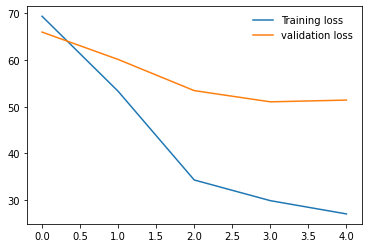

In [ ]:
from matplotlib import pyplot as plt

plt.plot(train_loss_data, label="Training loss")
plt.plot(valid_loss_data, label="validation loss")
plt.legend(frameon=False)

# Testing
To test this model, the left 15% data was used.

In [ ]:
model.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/Dataset/news_model1.pth", map_location = device))

<All keys matched successfully>

In [ ]:
all_preds = []
all_labels = []

for batch in test_dataloader:
    text, labels = batch
    inputs = tokenizer.batch_encode_plus(
        text, **tokenizer_config
    )
    input_ids = inputs['input_ids'].to(device)
    token_type_ids = inputs['token_type_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    labels = labels.to(device)

    # move things to model
    output = model(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)
    preds = output.detach().cpu().numpy()
    preds = np.argmax(preds, axis = 1)
    all_preds.extend(preds)
    all_labels.extend(labels.cpu().numpy())

In [ ]:
from sklearn.metrics import classification_report

# preds = np.argmax(preds, axis = 1)
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.86      0.75      0.80         8
           1       0.78      0.88      0.82         8

    accuracy                           0.81        16
   macro avg       0.82      0.81      0.81        16
weighted avg       0.82      0.81      0.81        16



In [ ]:
cf_matrix = confusion_matrix(all_labels, all_preds)  


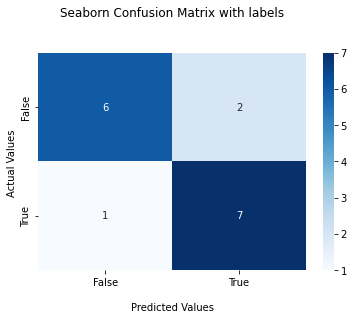

In [ ]:
import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score
test_accuracy1 = accuracy_score(all_labels, all_preds)
print('Accuracy: %.3f' % test_accuracy1)
precision = precision_score(all_labels, all_preds, average='macro')
print('Precision: %.3f' % precision)
recall = recall_score(all_labels, all_preds, average='macro')
print('Recall: %.3f' % recall)
score = f1_score(all_labels, all_preds, average='macro')
print('F-Measure: %.3f' % score)

Accuracy: 0.812
Precision: 0.817
Recall: 0.812
F-Measure: 0.812


In [ ]:
print(model.fc1.weight.data)

tensor([[ 2.1511e-02, -7.6198e-03,  3.0582e-02,  ..., -2.7826e-02,
         -1.4801e-02,  1.9146e-02],
        [ 1.8071e-02, -4.7941e-03,  1.5372e-02,  ...,  1.1259e-02,
         -3.0555e-02,  3.0235e-02],
        [-2.7836e-02,  2.6365e-02,  1.1362e-02,  ...,  2.8270e-02,
          2.9049e-02,  3.5623e-03],
        ...,
        [-1.1947e-04, -2.3521e-02,  2.9836e-02,  ...,  5.4116e-03,
         -1.0616e-02, -2.8621e-02],
        [-1.3557e-02,  7.1163e-03, -2.0381e-02,  ...,  3.6476e-03,
         -2.0447e-02,  2.1369e-02],
        [-2.1866e-02,  3.1834e-02, -2.8109e-02,  ...,  6.2409e-03,
          1.7802e-02, -4.1501e-05]], device='cuda:0')


#DATA SELECT

### Train and Test split: 
(only 20% data used for testing)
- Total Dataset size: 10392
- Total train size: 8313
- Test train size: 2079

In [ ]:
class NewsDatasets(Dataset):
    def __init__(self, data, max_length=100):
        self.data = data
        
        self.config = {
            "max_length": max_length,
            "padding": "max_length",
            "return_tensors": "pt",
            "truncation": True,
            "add_special_tokens": True
        }

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        value = self.data.iloc[idx]
        return value['head']+"[SEP]"+value['con'] , value['label']

In [ ]:
auth = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dataset/For Sentiment /Division /40%/auth_set_10.csv",encoding='UTF-8')
fake = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dataset/For Sentiment /Division /40%/fake_set_2.csv",encoding='UTF-8')


print(len(auth))
print(len(fake))


1497
40


In [ ]:

#df = auth[:fake.shape[0]* 7]
df = auth.append(fake)
df = df.sample(frac=1).reset_index(drop=True)
len(df)

1537

In [ ]:
from bnlp import BasicTokenizer
from bnlp.corpus import stopwords, punctuations, letters, digits

btokenizer = BasicTokenizer()

def clean_text(text):
    tokens = btokenizer.tokenize(text)
    filtered = []
    for i in tokens:
        if i in stopwords:
            continue
    
        if i in punctuations + '‘' + '’':
            continue
    
        filtered.append(i)
    
    return " ".join(filtered)

print("********** Before ***************")
text = df.iloc[1]['content']
print(text)
print("\n********** After ***************")
print(clean_text(text))

********** Before ***************
কামরুজ্জামান জসিম, মোংলা থেকে: মোংলা বন্দরের পশুর নদীতে কার্গো জাহাজ থেকে পড়ে মো. আসলাম (১৯) নামের এক নাবিক নিখোঁজ হয়েছেন। সে বাগেরহাট জেলার রামপাল উপজেলার পেড়িখালীর সিকির ডাংগা গ্রামের বাসিন্দা মো. আল আমিনের ছেলে বলে জানা গেছে। পুলিশ ও কার্গো জাহাজটির মাস্টার মো.দ হোসেন এ দূর্ঘটনার সত্যতা নিশ্চিত করেছেন। মঙ্গলবার দুপুর ১২ টার দিকে পশুর নদীর ইঞ্জিনিয়ারিং জেটি এলাকায় জাহাজ থেকে পড়ে সে নিখোঁজ হয়। বাংলাদেশ লাইটারেজ শ্রমিক ইউনিয়নের মোংলা আঞ্চলিক কমিটির সহ সভাপতি মাইনুল হোসেন মিন্টু জানান, বন্দরের পশুর নদীর ইঞ্জিনিয়ারিং জেটি এলাকায় এম ভি আয়শা বিবি কার্গো জাহাজ পণ্য খালাসের পর নোঙ্গর করা অবস্থায় ছিল। কাজ করার সময় পা ফসকে গিয়ে নদীতে পড়ে স্রোতের টানে নিখোঁজ হয় ওই জাহাজেরই নাবিক মো. আসলাম। দুর্ঘটনার পরপরই তার সহকর্মিরা দেড় ঘন্টা ধরে তাকে উদ্ধারে চেষ্টা চালিয়ে ব্যার্থ হয়েছেন। শেষ খবর পাওয়া পর্যন্ত ঘটনস্থালে পুলিশ বাংলাদেশ লাইটারেজ শ্রমিক ইউনিয়নের মোংলা আঞ্চলিক কমিটির সদস্য ও নিখোঁজের স্বজনেরা তল্লাশি চালাচ্ছে বলে জানা গেছে। বিডি২৪লাইভ/এমকে

********** After *

In [ ]:
undersample = RandomUnderSampler(sampling_strategy='majority')

In [ ]:
df['head'] = df.headline.apply(clean_text)
df['con'] = df.content.apply(clean_text)

In [ ]:
x= df.drop('label', axis=1)
y= df.label

In [ ]:
X_train_resampled, y_train_resampled = undersample.fit_resample(x, y)

In [ ]:
df = X_train_resampled.join(y_train_resampled)

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=121, stratify=df['label'])

In [ ]:
len(train_df), len(test_df)

(64, 16)

In [ ]:
training_data = NewsDatasets(train_df)
train_dataloader = DataLoader(training_data, batch_size=1, shuffle=True)

In [ ]:
test_data = NewsDatasets(test_df)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=True)

# 2nd model

In [ ]:
class NewsBert2(nn.Module):

    def __init__(self, bert):
        super(NewsBert2, self).__init__()

        self.bert = bert

        # dropout layer
        self.dropout = nn.Dropout(0.2)

        # relu activation function
        self.relu = nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768, 128)

        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(128, 2)  

    # define the forward pass
    def forward(self, input_ids, token_type_ids, attention_mask):
        # pass the inputs to the model
        out = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

        x = self.fc1(out[1])
        x = self.relu(x)
        # output layer
        x = self.fc2(self.dropout(x))
        
        return x

In [ ]:
bert_model_name = "sagorsarker/bangla-bert-base"
bert = BertModel.from_pretrained(bert_model_name)
tokenizer = BertTokenizer.from_pretrained(bert_model_name)

Some weights of the model checkpoint at sagorsarker/bangla-bert-base were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2 = NewsBert(bert)
model2.to(device);

In [ ]:
from torch.optim.lr_scheduler import StepLR

optimizer = AdamW(model2.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

In [ ]:
print(model2.fc1.weight.data)

tensor([[ 0.0116,  0.0323,  0.0219,  ..., -0.0255, -0.0328, -0.0164],
        [ 0.0081,  0.0202,  0.0271,  ...,  0.0123,  0.0130, -0.0098],
        [ 0.0062, -0.0050, -0.0048,  ..., -0.0240, -0.0321,  0.0351],
        ...,
        [-0.0127, -0.0340, -0.0035,  ..., -0.0157,  0.0171,  0.0353],
        [ 0.0349, -0.0315,  0.0103,  ..., -0.0236, -0.0085,  0.0283],
        [ 0.0036, -0.0296,  0.0173,  ...,  0.0203, -0.0176,  0.0006]],
       device='cuda:0')


In [ ]:
def train(model, dataloader, optimizer, criterion, config):
    model2.train()  # prep model for training
    train_loss = 0
    for batch in tqdm(dataloader):
        text, labels = batch

        model2.zero_grad()

        inputs = tokenizer.batch_encode_plus(
            text, **config
        )
        input_ids = inputs['input_ids'].to(device)
        token_type_ids = inputs['token_type_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        # move things to model
        logs = model2(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)

        loss = criterion(logs, labels)
        train_loss += loss.item() * input_ids.size(0)
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        nn.utils.clip_grad_norm_(model2.parameters(), 1.0)
        optimizer.step()

    return train_loss

In [ ]:
def evaluate(model, dataloader, criterion, config):
    total = 0
    correct = 0
    valid_loss = 0.0

    model2.eval()  # prep model for evaluation
    for batch in dataloader:
        text, labels = batch
        inputs = tokenizer.batch_encode_plus(
            text, **config
        )
        input_ids = inputs['input_ids'].to(device)
        token_type_ids = inputs['token_type_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        # move things to model
        output = model2(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)

        loss_p = criterion(output, labels)
        # update running validation loss
        valid_loss += loss_p.item() * input_ids.size(0)
        # calculate accuracy
        proba = torch.exp(output)
        top_p, top_class = proba.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        # accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return total, correct, valid_loss

In [ ]:
epochs = 5
tokenizer_config = {
    "max_length": 100,
    "padding": "max_length",
    "return_tensors": "pt",
    "truncation": True,
    "add_special_tokens": True
}

In [ ]:
train_loss_data, valid_loss_data = [], []
valid_loss_min = np.Inf
since = time.time()
best_loss = np.inf

for epoch in range(epochs):
    print("Epoch: {}/{}".format(epoch + 1, epochs))
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    total = 0
    correct = 0
    e_since = time.time()

    # Train Model
    train_loss += train(model2, train_dataloader, optimizer, criterion, tokenizer_config)
    # Now Evaluate
    out = evaluate(model2, test_dataloader, criterion, tokenizer_config)
    total += out[0]
    correct += out[1]
    valid_loss += out[2]
    
    scheduler.step()

    # print training/validation statistics
    # calculate average loss over an epoch
    train_loss = train_loss / len(train_dataloader.dataset)
    valid_loss = valid_loss / len(test_dataloader.dataset)

    # calculate train loss and running loss
    train_loss_data.append(train_loss * 100)
    valid_loss_data.append(valid_loss * 100)
    
    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(model2.state_dict(), "/content/drive/MyDrive/Colab Notebooks/Dataset/news_model2.pth")

    print("\tTrain loss:{:.6f}..".format(train_loss),
          "\tValid Loss:{:.6f}..".format(valid_loss),
          "\tAccuracy: {:.4f}".format(correct / total * 100))

time_elapsed = time.time() - since
print('Training completed in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

Epoch: 1/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.698045.. 	Valid Loss:0.656285.. 	Accuracy: 81.2500
Epoch: 2/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.632892.. 	Valid Loss:0.602271.. 	Accuracy: 68.7500
Epoch: 3/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.451631.. 	Valid Loss:0.562399.. 	Accuracy: 75.0000
Epoch: 4/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.398364.. 	Valid Loss:0.547309.. 	Accuracy: 81.2500
Epoch: 5/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.374831.. 	Valid Loss:0.545253.. 	Accuracy: 81.2500
Training completed in 0m 53s


In [ ]:
class NewsBert2(nn.Module):

    def __init__(self, bert):
        super(NewsBert2, self).__init__()

        self.bert = bert

        # dropout layer
        self.dropout = nn.Dropout(0.2)

        # relu activation function
        self.relu = nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768, 128)

        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(128, 2)  

    # define the forward pass
    def forward(self, input_ids, token_type_ids, attention_mask):
        # pass the inputs to the model
        out = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

        x = self.fc1(out[1])
        x = self.relu(x)
        # output layer
        x = self.fc2(self.dropout(x))
        
        return x

In [ ]:
bert_model_name = "sagorsarker/bangla-bert-base"
bert = BertModel.from_pretrained(bert_model_name)
tokenizer = BertTokenizer.from_pretrained(bert_model_name)

Some weights of the model checkpoint at sagorsarker/bangla-bert-base were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2 = NewsBert(bert)
model2.to(device);

In [ ]:
from torch.optim.lr_scheduler import StepLR

optimizer = AdamW(model2.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

In [ ]:
model2.fc1.weight.data =model.fc1.weight.data.clone()
model2.fc1.bias.data =model.fc1.bias.data.clone()
model2.fc2.weight.data =model.fc2.weight.data.clone()
model2.fc2.bias.data =model.fc2.bias.data.clone()

In [ ]:
print(model2.fc1.weight.data)

tensor([[ 2.1511e-02, -7.6198e-03,  3.0582e-02,  ..., -2.7826e-02,
         -1.4801e-02,  1.9146e-02],
        [ 1.8071e-02, -4.7941e-03,  1.5372e-02,  ...,  1.1259e-02,
         -3.0555e-02,  3.0235e-02],
        [-2.7836e-02,  2.6365e-02,  1.1362e-02,  ...,  2.8270e-02,
          2.9049e-02,  3.5623e-03],
        ...,
        [-1.1947e-04, -2.3521e-02,  2.9836e-02,  ...,  5.4116e-03,
         -1.0616e-02, -2.8621e-02],
        [-1.3557e-02,  7.1163e-03, -2.0381e-02,  ...,  3.6476e-03,
         -2.0447e-02,  2.1369e-02],
        [-2.1866e-02,  3.1834e-02, -2.8109e-02,  ...,  6.2409e-03,
          1.7802e-02, -4.1501e-05]], device='cuda:0')


In [ ]:
def train(model, dataloader, optimizer, criterion, config):
    model2.train()  # prep model for training
    train_loss = 0
    for batch in tqdm(dataloader):
        text, labels = batch

        model2.zero_grad()

        inputs = tokenizer.batch_encode_plus(
            text, **config
        )
        input_ids = inputs['input_ids'].to(device)
        token_type_ids = inputs['token_type_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        # move things to model
        logs = model2(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)

        loss = criterion(logs, labels)
        train_loss += loss.item() * input_ids.size(0)
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        nn.utils.clip_grad_norm_(model2.parameters(), 1.0)
        optimizer.step()

    return train_loss

In [ ]:
def evaluate(model, dataloader, criterion, config):
    total = 0
    correct = 0
    valid_loss = 0.0

    model2.eval()  # prep model for evaluation
    for batch in dataloader:
        text, labels = batch
        inputs = tokenizer.batch_encode_plus(
            text, **config
        )
        input_ids = inputs['input_ids'].to(device)
        token_type_ids = inputs['token_type_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        # move things to model
        output = model2(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)

        loss_p = criterion(output, labels)
        # update running validation loss
        valid_loss += loss_p.item() * input_ids.size(0)
        # calculate accuracy
        proba = torch.exp(output)
        top_p, top_class = proba.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        # accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return total, correct, valid_loss

In [ ]:
epochs = 5
tokenizer_config = {
    "max_length": 100,
    "padding": "max_length",
    "return_tensors": "pt",
    "truncation": True,
    "add_special_tokens": True
}

In [ ]:
train_loss_data, valid_loss_data = [], []
valid_loss_min = np.Inf
since = time.time()
best_loss = np.inf

for epoch in range(epochs):
    print("Epoch: {}/{}".format(epoch + 1, epochs))
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    total = 0
    correct = 0
    e_since = time.time()

    # Train Model
    train_loss += train(model2, train_dataloader, optimizer, criterion, tokenizer_config)
    # Now Evaluate
    out = evaluate(model2, test_dataloader, criterion, tokenizer_config)
    total += out[0]
    correct += out[1]
    valid_loss += out[2]
    
    scheduler.step()

    # print training/validation statistics
    # calculate average loss over an epoch
    train_loss = train_loss / len(train_dataloader.dataset)
    valid_loss = valid_loss / len(test_dataloader.dataset)

    # calculate train loss and running loss
    train_loss_data.append(train_loss * 100)
    valid_loss_data.append(valid_loss * 100)
    
    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(model2.state_dict(), "/content/drive/MyDrive/Colab Notebooks/Dataset/news_model2.pth")

    print("\tTrain loss:{:.6f}..".format(train_loss),
          "\tValid Loss:{:.6f}..".format(valid_loss),
          "\tAccuracy: {:.4f}".format(correct / total * 100))

time_elapsed = time.time() - since
print('Training completed in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

Epoch: 1/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.723058.. 	Valid Loss:0.615703.. 	Accuracy: 87.5000
Epoch: 2/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.511852.. 	Valid Loss:0.476641.. 	Accuracy: 81.2500
Epoch: 3/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.277600.. 	Valid Loss:0.390446.. 	Accuracy: 93.7500
Epoch: 4/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.229033.. 	Valid Loss:0.381941.. 	Accuracy: 81.2500
Epoch: 5/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.191829.. 	Valid Loss:0.377545.. 	Accuracy: 87.5000
Training completed in 1m 0s


In [ ]:
training_acc2 = correct / total * 100
training_acc2

87.5

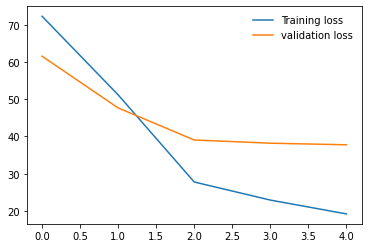

In [ ]:
from matplotlib import pyplot as plt

plt.plot(train_loss_data, label="Training loss")
plt.plot(valid_loss_data, label="validation loss")
plt.legend(frameon=False)

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
from google.colab import output
output.disable_custom_widget_manager()

In [ ]:
model2.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/Dataset/news_model2.pth", map_location = device))

<All keys matched successfully>

In [ ]:
all_preds = []
all_labels = []

for batch in test_dataloader:
    text, labels = batch
    inputs = tokenizer.batch_encode_plus(
        text, **tokenizer_config
    )
    input_ids = inputs['input_ids'].to(device)
    token_type_ids = inputs['token_type_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    labels = labels.to(device)

    # move things to model
    output = model2(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)
    preds = output.detach().cpu().numpy()
    preds = np.argmax(preds, axis = 1)
    all_preds.extend(preds)
    all_labels.extend(labels.cpu().numpy())

In [ ]:
from sklearn.metrics import classification_report

# preds = np.argmax(preds, axis = 1)
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.80      1.00      0.89         8
           1       1.00      0.75      0.86         8

    accuracy                           0.88        16
   macro avg       0.90      0.88      0.87        16
weighted avg       0.90      0.88      0.87        16



In [ ]:
print(model2.fc1.weight.data)

tensor([[ 0.0216, -0.0073,  0.0304,  ..., -0.0277, -0.0146,  0.0193],
        [ 0.0180, -0.0051,  0.0156,  ...,  0.0111, -0.0308,  0.0300],
        [-0.0281,  0.0260,  0.0117,  ...,  0.0284,  0.0287,  0.0032],
        ...,
        [-0.0003, -0.0238,  0.0302,  ...,  0.0052, -0.0108, -0.0289],
        [-0.0134,  0.0074, -0.0208,  ...,  0.0035, -0.0201,  0.0218],
        [-0.0223,  0.0314, -0.0277,  ...,  0.0063,  0.0174, -0.0004]],
       device='cuda:0')


In [ ]:
cf_matrix = confusion_matrix(all_labels, all_preds)  

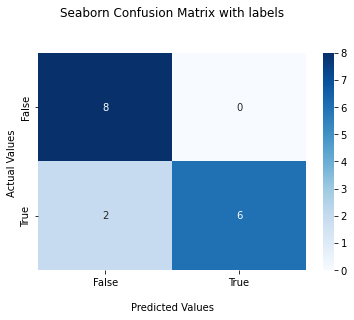

In [ ]:
import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score
test_accuracy2 = accuracy_score(all_labels, all_preds)
print('Accuracy: %.3f' % test_accuracy2)
precision2 = precision_score(all_labels, all_preds, average='macro')
print('Precision: %.3f' % precision2)
recall2 = recall_score(all_labels, all_preds, average='macro')
print('Recall: %.3f' % recall2)
score2 = f1_score(all_labels, all_preds, average='macro')
print('F-Measure: %.3f' % score2)

Accuracy: 0.875
Precision: 0.900
Recall: 0.875
F-Measure: 0.873


# For Looping

In [ ]:
if precision2 >= precision and recall2 >= recall and score2 >= score :
  torch.save(model2.state_dict(), "/content/drive/MyDrive/Colab Notebooks/Dataset/news_model1.pth")
  precision = precision2
  recall = recall2
  score = score2
  model.fc1.weight.data =model2.fc1.weight.data.clone()
  model.fc1.bias.data =model2.fc1.bias.data.clone()
  model.fc2.weight.data =model2.fc2.weight.data.clone()
  model.fc2.bias.data =model2.fc2.bias.data.clone()

# 3rd Model


In [ ]:
class NewsDatasets(Dataset):
    def __init__(self, data, max_length=100):
        self.data = data
        
        self.config = {
            "max_length": max_length,
            "padding": "max_length",
            "return_tensors": "pt",
            "truncation": True,
            "add_special_tokens": True
        }

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        value = self.data.iloc[idx]
        return value['head']+"[SEP]"+value['con'] , value['label']

In [ ]:
auth = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dataset/For Sentiment /Division /40%/auth_set_3.csv",encoding='UTF-8')
fake = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dataset/For Sentiment /Division /40%/fake_set_3.csv",encoding='UTF-8')


print(len(auth))
print(len(fake))


1497
40


In [ ]:

#df = auth[:fake.shape[0]* 7]
df = auth.append(fake)
df = df.sample(frac=1).reset_index(drop=True)
len(df)

1537

In [ ]:
from bnlp import BasicTokenizer
from bnlp.corpus import stopwords, punctuations, letters, digits

btokenizer = BasicTokenizer()

def clean_text(text):
    tokens = btokenizer.tokenize(text)
    filtered = []
    for i in tokens:
        if i in stopwords:
            continue
    
        if i in punctuations + '‘' + '’':
            continue
    
        filtered.append(i)
    
    return " ".join(filtered)

print("********** Before ***************")
text = df.iloc[1]['content']
print(text)
print("\n********** After ***************")
print(clean_text(text))

********** Before ***************
ক্রীড়া ডেস্ক: বিশ্রামে থাকার কথা জানিয়ে গত মাসে ক্রোয়েশিয়া ও ইতালির বিপক্ষে ম্যাচে পর্তুগাল দলে ছিলেন না ক্রিস্টিয়ানো রোনালদো।  এই মাসেও দুটি আন্তর্জাতিক ম্যাচে পর্তুগালের হয়ে খেলবেন না জুভেন্টাস এ তারকা। চলতি মাসে পোল্যান্ড ও স্কটল্যান্ডের বিপক্ষে দুটি ম্যাচ খেলবে রোনালেদোর দেশ পর্তুগাল। গত মাসে জাতীয় দলের হয়ে না খেলায় এই মাসে অধিনায়ক রোনালদোকে দলে প্রত্যাশা করেছিল পর্তুগাল ভক্তরা।  কিন্তু এই মাসেও পর্তুগালের জার্সিতে রোনালদো থাকবে না বলে এক প্রতিবেদনে জানিয়েছে বিবিসি স্পোর্টস। নতুন ক্লাব জুভেন্টাসের হয়ে সবশেষ চ্যাম্পিয়নস লিগের ম্যাচে দর্শক হিসেবে খেলা দেখতে হয়েছে রোনালদো। এর আগে চ্যাম্পিয়নস লিগ অভিষেকে লাল কার্ড দেখায় ওল্ড বয়েজের বিপক্ষে পরের ম্যাচে খেলতে পারেননি রোনালদো। মৌসুমের শুরুতে ১০০ মিলিয়ন ইউরোতে রিয়াল মাদ্রিদ থেকে জুভেন্টাসে যোগ দিয়েছেন রোনালদো। নতুন ক্লাবের সঙ্গে মানিয়ে নিতেই নাকি পর্তুগালের গত দুই ম্যাচে তাকে বিশ্রাম দিয়েছিলেন দেশটির কোচ। পাঁচ বারের ব্যালন ডি’অর জয়ী রোনালদো পর্তুগালের হয়ে এ পর্যন্ত ১৫৪ ম্যাচে মাঠে নেমেছেন। এর মধ্যে মোট ৮৫ট

In [ ]:
undersample = RandomUnderSampler(sampling_strategy='majority')

In [ ]:
df['head'] = df.headline.apply(clean_text)
df['con'] = df.content.apply(clean_text)

In [ ]:
x= df.drop('label', axis=1)
y= df.label

In [ ]:
X_train_resampled, y_train_resampled = undersample.fit_resample(x, y)

In [ ]:
df = X_train_resampled.join(y_train_resampled)

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=121, stratify=df['label'])

In [ ]:
len(train_df), len(test_df)

(64, 16)

In [ ]:
training_data = NewsDatasets(train_df)
train_dataloader = DataLoader(training_data, batch_size=1, shuffle=True)

In [ ]:
test_data = NewsDatasets(test_df)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=True)

In [ ]:
class NewsBert2(nn.Module):

    def __init__(self, bert):
        super(NewsBert2, self).__init__()

        self.bert = bert

        # dropout layer
        self.dropout = nn.Dropout(0.2)

        # relu activation function
        self.relu = nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768, 128)

        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(128, 2)  

    # define the forward pass
    def forward(self, input_ids, token_type_ids, attention_mask):
        # pass the inputs to the model
        out = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

        x = self.fc1(out[1])
        x = self.relu(x)
        # output layer
        x = self.fc2(self.dropout(x))
        
        return x

In [ ]:
bert_model_name = "sagorsarker/bangla-bert-base"
bert = BertModel.from_pretrained(bert_model_name)
tokenizer = BertTokenizer.from_pretrained(bert_model_name)

Some weights of the model checkpoint at sagorsarker/bangla-bert-base were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2 = NewsBert(bert)
model2.to(device);

In [ ]:
from torch.optim.lr_scheduler import StepLR

optimizer = AdamW(model2.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

In [ ]:
model2.fc1.weight.data =model.fc1.weight.data.clone()
model2.fc1.bias.data =model.fc1.bias.data.clone()
model2.fc2.weight.data =model.fc2.weight.data.clone()
model2.fc2.bias.data =model.fc2.bias.data.clone()

In [ ]:
print(model2.fc1.weight.data)

tensor([[ 0.0216, -0.0073,  0.0304,  ..., -0.0277, -0.0146,  0.0193],
        [ 0.0180, -0.0051,  0.0156,  ...,  0.0111, -0.0308,  0.0300],
        [-0.0281,  0.0260,  0.0117,  ...,  0.0284,  0.0287,  0.0032],
        ...,
        [-0.0003, -0.0238,  0.0302,  ...,  0.0052, -0.0108, -0.0289],
        [-0.0134,  0.0074, -0.0208,  ...,  0.0035, -0.0201,  0.0218],
        [-0.0223,  0.0314, -0.0277,  ...,  0.0063,  0.0174, -0.0004]],
       device='cuda:0')


In [ ]:
def train(model, dataloader, optimizer, criterion, config):
    model2.train()  # prep model for training
    train_loss = 0
    for batch in tqdm(dataloader):
        text, labels = batch

        model2.zero_grad()

        inputs = tokenizer.batch_encode_plus(
            text, **config
        )
        input_ids = inputs['input_ids'].to(device)
        token_type_ids = inputs['token_type_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        # move things to model
        logs = model2(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)

        loss = criterion(logs, labels)
        train_loss += loss.item() * input_ids.size(0)
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        nn.utils.clip_grad_norm_(model2.parameters(), 1.0)
        optimizer.step()

    return train_loss

In [ ]:
def evaluate(model, dataloader, criterion, config):
    total = 0
    correct = 0
    valid_loss = 0.0

    model2.eval()  # prep model for evaluation
    for batch in dataloader:
        text, labels = batch
        inputs = tokenizer.batch_encode_plus(
            text, **config
        )
        input_ids = inputs['input_ids'].to(device)
        token_type_ids = inputs['token_type_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        # move things to model
        output = model2(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)

        loss_p = criterion(output, labels)
        # update running validation loss
        valid_loss += loss_p.item() * input_ids.size(0)
        # calculate accuracy
        proba = torch.exp(output)
        top_p, top_class = proba.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        # accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return total, correct, valid_loss

In [ ]:
epochs = 5
tokenizer_config = {
    "max_length": 100,
    "padding": "max_length",
    "return_tensors": "pt",
    "truncation": True,
    "add_special_tokens": True
}

In [ ]:
train_loss_data, valid_loss_data = [], []
valid_loss_min = np.Inf
since = time.time()
best_loss = np.inf

for epoch in range(epochs):
    print("Epoch: {}/{}".format(epoch + 1, epochs))
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    total = 0
    correct = 0
    e_since = time.time()

    # Train Model
    train_loss += train(model2, train_dataloader, optimizer, criterion, tokenizer_config)
    # Now Evaluate
    out = evaluate(model2, test_dataloader, criterion, tokenizer_config)
    total += out[0]
    correct += out[1]
    valid_loss += out[2]
    
    scheduler.step()

    # print training/validation statistics
    # calculate average loss over an epoch
    train_loss = train_loss / len(train_dataloader.dataset)
    valid_loss = valid_loss / len(test_dataloader.dataset)

    # calculate train loss and running loss
    train_loss_data.append(train_loss * 100)
    valid_loss_data.append(valid_loss * 100)
    
    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(model2.state_dict(), "/content/drive/MyDrive/Colab Notebooks/Dataset/news_model2.pth")

    print("\tTrain loss:{:.6f}..".format(train_loss),
          "\tValid Loss:{:.6f}..".format(valid_loss),
          "\tAccuracy: {:.4f}".format(correct / total * 100))

time_elapsed = time.time() - since
print('Training completed in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

Epoch: 1/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.649429.. 	Valid Loss:0.591774.. 	Accuracy: 81.2500
Epoch: 2/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.403506.. 	Valid Loss:0.680381.. 	Accuracy: 75.0000
Epoch: 3/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.196765.. 	Valid Loss:0.586800.. 	Accuracy: 81.2500
Epoch: 4/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.133735.. 	Valid Loss:0.593656.. 	Accuracy: 81.2500
Epoch: 5/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.117366.. 	Valid Loss:0.590779.. 	Accuracy: 81.2500
Training completed in 0m 48s


In [ ]:
training_acc3 = correct / total * 100
training_acc3

81.25

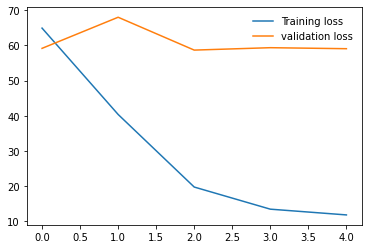

In [ ]:
from matplotlib import pyplot as plt

plt.plot(train_loss_data, label="Training loss")
plt.plot(valid_loss_data, label="validation loss")
plt.legend(frameon=False)

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
from google.colab import output
output.disable_custom_widget_manager()

In [ ]:
model2.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/Dataset/news_model2.pth", map_location = device))

<All keys matched successfully>

In [ ]:
all_preds = []
all_labels = []

for batch in test_dataloader:
    text, labels = batch
    inputs = tokenizer.batch_encode_plus(
        text, **tokenizer_config
    )
    input_ids = inputs['input_ids'].to(device)
    token_type_ids = inputs['token_type_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    labels = labels.to(device)

    # move things to model
    output = model2(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)
    preds = output.detach().cpu().numpy()
    preds = np.argmax(preds, axis = 1)
    all_preds.extend(preds)
    all_labels.extend(labels.cpu().numpy())

In [ ]:
from sklearn.metrics import classification_report

# preds = np.argmax(preds, axis = 1)
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       1.00      0.62      0.77         8
           1       0.73      1.00      0.84         8

    accuracy                           0.81        16
   macro avg       0.86      0.81      0.81        16
weighted avg       0.86      0.81      0.81        16



In [ ]:
print(model2.fc1.weight.data)

tensor([[ 0.0217, -0.0068,  0.0298,  ..., -0.0273, -0.0143,  0.0196],
        [ 0.0179, -0.0055,  0.0158,  ...,  0.0110, -0.0311,  0.0300],
        [-0.0283,  0.0257,  0.0122,  ...,  0.0285,  0.0284,  0.0029],
        ...,
        [-0.0004, -0.0242,  0.0303,  ...,  0.0053, -0.0111, -0.0289],
        [-0.0133,  0.0077, -0.0210,  ...,  0.0036, -0.0200,  0.0220],
        [-0.0225,  0.0308, -0.0271,  ...,  0.0064,  0.0169, -0.0005]],
       device='cuda:0')


In [ ]:
cf_matrix = confusion_matrix(all_labels, all_preds)  


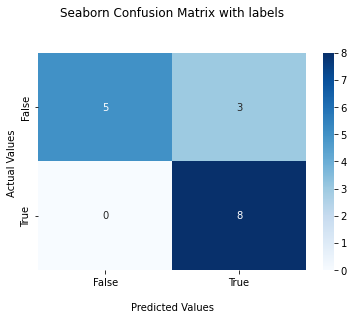

In [ ]:
import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score
test_accuracy3 = accuracy_score(all_labels, all_preds)
print('Accuracy: %.3f' % test_accuracy3)
precision3 = precision_score(all_labels, all_preds, average='macro')
print('Precision: %.3f' % precision3)
recall3 = recall_score(all_labels, all_preds, average='macro')
print('Recall: %.3f' % recall3)
score3 = f1_score(all_labels, all_preds, average='macro')
print('F-Measure: %.3f' % score3)

Accuracy: 0.812
Precision: 0.864
Recall: 0.812
F-Measure: 0.806


# For Looping

In [ ]:
if precision3 >= precision and recall3 >= recall and score3 >= score :
  torch.save(model2.state_dict(), "/content/drive/MyDrive/Colab Notebooks/Dataset/news_model1.pth")
  precision = precision3
  recall = recall3
  score = score3
  model.fc1.weight.data =model2.fc1.weight.data.clone()
  model.fc1.bias.data =model2.fc1.bias.data.clone()
  model.fc2.weight.data =model2.fc2.weight.data.clone()
  model.fc2.bias.data =model2.fc2.bias.data.clone()

# 4th Model


In [ ]:
class NewsDatasets(Dataset):
    def __init__(self, data, max_length=100):
        self.data = data
        
        self.config = {
            "max_length": max_length,
            "padding": "max_length",
            "return_tensors": "pt",
            "truncation": True,
            "add_special_tokens": True
        }

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        value = self.data.iloc[idx]
        return value['head']+"[SEP]"+value['con'] , value['label']

In [ ]:
auth = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dataset/For Sentiment /Division /40%/auth_set_4.csv",encoding='UTF-8')
fake = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dataset/For Sentiment /Division /40%/fake_set_4.csv",encoding='UTF-8')


print(len(auth))
print(len(fake))


1497
40


In [ ]:

#df = auth[:fake.shape[0]* 7]
df = auth.append(fake)
df = df.sample(frac=1).reset_index(drop=True)
len(df)

1537

In [ ]:
from bnlp import BasicTokenizer
from bnlp.corpus import stopwords, punctuations, letters, digits

btokenizer = BasicTokenizer()

def clean_text(text):
    tokens = btokenizer.tokenize(text)
    filtered = []
    for i in tokens:
        if i in stopwords:
            continue
    
        if i in punctuations + '‘' + '’':
            continue
    
        filtered.append(i)
    
    return " ".join(filtered)

print("********** Before ***************")
text = df.iloc[1]['content']
print(text)
print("\n********** After ***************")
print(clean_text(text))

********** Before ***************
চট্টগ্রাম: নগরের নাসিরাবাদ হাউজিং সোসাইটির সানশাইন গ্রামার স্কুল উদ্বোধন হলো পে ইট ফরওয়ার্ড বাংলাদেশের ‘দানে আনে’ কর্নার। যেখানে লেখা আছে ‘আপনার অপ্রয়োজনীয় জিনিস এখানে রেখে যান। আমরা আপনার হয়ে তা দুস্থদের কাছে পৌঁছে দেবো।’ বৃহস্পতিবার (৪ অক্টোবর) ‘দানে আনে’ কর্নার উদ্বোধন অনুষ্ঠানে উপস্থিত ছিলেন পে ইট ফরওয়ার্ড বাংলাদেশের প্রধান সমন্বয়ক বাদল সৈয়দ, সানশাইন গ্রামার স্কুল অ্যান্ড কলেজের অধ্যক্ষ সাফিয়া গাজী রহমান, কবি আকতার হোসাইন প্রমুখ। সাফিয়া গাজী রহমান বাংলানিউজকে জানান, মানুষের জন্য কাজ করার আনন্দ অনেক। দেওয়ার মধ্যে যে আনন্দ তা আমাদের শিক্ষার্থীদের মধ্যে ছড়িয়ে দিতে চাই আমরা। পে ইট ফরওয়ার্ড বাংলাদেশ ‘দানে আনে’ কর্নার চালু করেছে আমাদের শিক্ষাপ্রতিষ্ঠানে। শিক্ষক-শিক্ষার্থীদের বাসায় যেসব পুরোনো জিনিসপত্র, কাপড়, খাতা-কলম, ওষুধসহ নিত্যপ্রয়োজনীয় পণ্য পড়ে থাকে সেগুলো এখানে জমা দেবে, বাক্স ভরে গেলে আমরা খবর দেব পে ইট ফরওয়ার্ড বাংলাদেশকে। তারা প্রয়োজন অনুযায়ী দুস্থদের মধ্যে সেগুলো বিতরণ করবে, পৌঁছে দেবে। নিঃসন্দেহে এটি মহৎ উদ্যোগ। তিনি বলেন, আমরা নিয়মিত শিক্ষার্

In [ ]:
undersample = RandomUnderSampler(sampling_strategy='majority')

In [ ]:
df['head'] = df.headline.apply(clean_text)
df['con'] = df.content.apply(clean_text)

In [ ]:
x= df.drop('label', axis=1)
y= df.label

In [ ]:
X_train_resampled, y_train_resampled = undersample.fit_resample(x, y)

In [ ]:
df = X_train_resampled.join(y_train_resampled)

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=121, stratify=df['label'])

In [ ]:
len(train_df), len(test_df)

(64, 16)

In [ ]:
training_data = NewsDatasets(train_df)
train_dataloader = DataLoader(training_data, batch_size=1, shuffle=True)

In [ ]:
test_data = NewsDatasets(test_df)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=True)

In [ ]:
class NewsBert2(nn.Module):

    def __init__(self, bert):
        super(NewsBert2, self).__init__()

        self.bert = bert

        # dropout layer
        self.dropout = nn.Dropout(0.2)

        # relu activation function
        self.relu = nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768, 128)

        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(128, 2)  

    # define the forward pass
    def forward(self, input_ids, token_type_ids, attention_mask):
        # pass the inputs to the model
        out = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

        x = self.fc1(out[1])
        x = self.relu(x)
        # output layer
        x = self.fc2(self.dropout(x))
        
        return x

In [ ]:
bert_model_name = "sagorsarker/bangla-bert-base"
bert = BertModel.from_pretrained(bert_model_name)
tokenizer = BertTokenizer.from_pretrained(bert_model_name)

Some weights of the model checkpoint at sagorsarker/bangla-bert-base were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2 = NewsBert(bert)
model2.to(device);

In [ ]:
from torch.optim.lr_scheduler import StepLR

optimizer = AdamW(model2.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

In [ ]:
model2.fc1.weight.data =model.fc1.weight.data.clone()
model2.fc1.bias.data =model.fc1.bias.data.clone()
model2.fc2.weight.data =model.fc2.weight.data.clone()
model2.fc2.bias.data =model.fc2.bias.data.clone()

In [ ]:
print(model2.fc1.weight.data)

tensor([[ 0.0216, -0.0073,  0.0304,  ..., -0.0277, -0.0146,  0.0193],
        [ 0.0180, -0.0051,  0.0156,  ...,  0.0111, -0.0308,  0.0300],
        [-0.0281,  0.0260,  0.0117,  ...,  0.0284,  0.0287,  0.0032],
        ...,
        [-0.0003, -0.0238,  0.0302,  ...,  0.0052, -0.0108, -0.0289],
        [-0.0134,  0.0074, -0.0208,  ...,  0.0035, -0.0201,  0.0218],
        [-0.0223,  0.0314, -0.0277,  ...,  0.0063,  0.0174, -0.0004]],
       device='cuda:0')


In [ ]:
def train(model, dataloader, optimizer, criterion, config):
    model2.train()  # prep model for training
    train_loss = 0
    for batch in tqdm(dataloader):
        text, labels = batch

        model2.zero_grad()

        inputs = tokenizer.batch_encode_plus(
            text, **config
        )
        input_ids = inputs['input_ids'].to(device)
        token_type_ids = inputs['token_type_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        # move things to model
        logs = model2(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)

        loss = criterion(logs, labels)
        train_loss += loss.item() * input_ids.size(0)
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        nn.utils.clip_grad_norm_(model2.parameters(), 1.0)
        optimizer.step()

    return train_loss

In [ ]:
def evaluate(model, dataloader, criterion, config):
    total = 0
    correct = 0
    valid_loss = 0.0

    model2.eval()  # prep model for evaluation
    for batch in dataloader:
        text, labels = batch
        inputs = tokenizer.batch_encode_plus(
            text, **config
        )
        input_ids = inputs['input_ids'].to(device)
        token_type_ids = inputs['token_type_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        # move things to model
        output = model2(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)

        loss_p = criterion(output, labels)
        # update running validation loss
        valid_loss += loss_p.item() * input_ids.size(0)
        # calculate accuracy
        proba = torch.exp(output)
        top_p, top_class = proba.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        # accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return total, correct, valid_loss

In [ ]:
epochs = 5
tokenizer_config = {
    "max_length": 100,
    "padding": "max_length",
    "return_tensors": "pt",
    "truncation": True,
    "add_special_tokens": True
}

In [ ]:
train_loss_data, valid_loss_data = [], []
valid_loss_min = np.Inf
since = time.time()
best_loss = np.inf

for epoch in range(epochs):
    print("Epoch: {}/{}".format(epoch + 1, epochs))
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    total = 0
    correct = 0
    e_since = time.time()

    # Train Model
    train_loss += train(model2, train_dataloader, optimizer, criterion, tokenizer_config)
    # Now Evaluate
    out = evaluate(model2, test_dataloader, criterion, tokenizer_config)
    total += out[0]
    correct += out[1]
    valid_loss += out[2]
    
    scheduler.step()

    # print training/validation statistics
    # calculate average loss over an epoch
    train_loss = train_loss / len(train_dataloader.dataset)
    valid_loss = valid_loss / len(test_dataloader.dataset)

    # calculate train loss and running loss
    train_loss_data.append(train_loss * 100)
    valid_loss_data.append(valid_loss * 100)
    
    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(model2.state_dict(), "/content/drive/MyDrive/Colab Notebooks/Dataset/news_model2.pth")

    print("\tTrain loss:{:.6f}..".format(train_loss),
          "\tValid Loss:{:.6f}..".format(valid_loss),
          "\tAccuracy: {:.4f}".format(correct / total * 100))

time_elapsed = time.time() - since
print('Training completed in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

Epoch: 1/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.717716.. 	Valid Loss:0.635473.. 	Accuracy: 81.2500
Epoch: 2/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.537701.. 	Valid Loss:0.365735.. 	Accuracy: 87.5000
Epoch: 3/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.273266.. 	Valid Loss:0.351488.. 	Accuracy: 87.5000
Epoch: 4/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.221416.. 	Valid Loss:0.337704.. 	Accuracy: 87.5000
Epoch: 5/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.208313.. 	Valid Loss:0.336725.. 	Accuracy: 87.5000
Training completed in 0m 52s


In [ ]:
training_acc4 = correct / total * 100
training_acc4

87.5

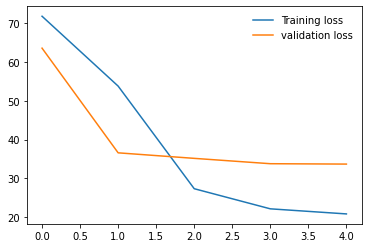

In [ ]:
from matplotlib import pyplot as plt

plt.plot(train_loss_data, label="Training loss")
plt.plot(valid_loss_data, label="validation loss")
plt.legend(frameon=False)

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
from google.colab import output
output.disable_custom_widget_manager()

In [ ]:
model2.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/Dataset/news_model2.pth", map_location = device))

<All keys matched successfully>

In [ ]:
all_preds = []
all_labels = []

for batch in test_dataloader:
    text, labels = batch
    inputs = tokenizer.batch_encode_plus(
        text, **tokenizer_config
    )
    input_ids = inputs['input_ids'].to(device)
    token_type_ids = inputs['token_type_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    labels = labels.to(device)

    # move things to model
    output = model2(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)
    preds = output.detach().cpu().numpy()
    preds = np.argmax(preds, axis = 1)
    all_preds.extend(preds)
    all_labels.extend(labels.cpu().numpy())

In [ ]:
from sklearn.metrics import classification_report

# preds = np.argmax(preds, axis = 1)
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88         8
           1       0.88      0.88      0.88         8

    accuracy                           0.88        16
   macro avg       0.88      0.88      0.88        16
weighted avg       0.88      0.88      0.88        16



In [ ]:
print(model2.fc1.weight.data)

tensor([[ 0.0214, -0.0070,  0.0302,  ..., -0.0276, -0.0144,  0.0195],
        [ 0.0177, -0.0055,  0.0156,  ...,  0.0112, -0.0310,  0.0300],
        [-0.0284,  0.0256,  0.0121,  ...,  0.0284,  0.0284,  0.0028],
        ...,
        [-0.0004, -0.0241,  0.0300,  ...,  0.0052, -0.0110, -0.0291],
        [-0.0132,  0.0079, -0.0211,  ...,  0.0034, -0.0197,  0.0221],
        [-0.0225,  0.0310, -0.0273,  ...,  0.0061,  0.0171, -0.0009]],
       device='cuda:0')


In [ ]:
cf_matrix = confusion_matrix(all_labels, all_preds)  

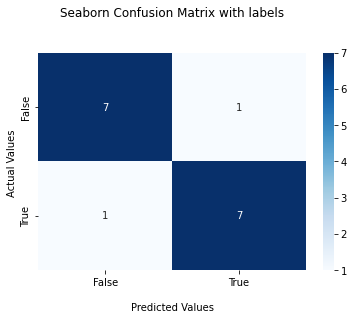

In [ ]:
import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score
test_accuracy4 = accuracy_score(all_labels, all_preds)
print('Accuracy: %.3f' % test_accuracy4)
precision4 = precision_score(all_labels, all_preds, average='macro')
print('Precision: %.3f' % precision4)
recall4 = recall_score(all_labels, all_preds, average='macro')
print('Recall: %.3f' % recall4)
score4 = f1_score(all_labels, all_preds, average='macro')
print('F-Measure: %.3f' % score4)

Accuracy: 0.875
Precision: 0.875
Recall: 0.875
F-Measure: 0.875


# For Looping

In [ ]:
if precision4 >= precision and recall >= recall3 and score4 >= score :
  torch.save(model2.state_dict(), "/content/drive/MyDrive/Colab Notebooks/Dataset/news_model1.pth")
  precision = precision4
  recall = recall4
  score = score4
  model.fc1.weight.data =model2.fc1.weight.data.clone()
  model.fc1.bias.data =model2.fc1.bias.data.clone()
  model.fc2.weight.data =model2.fc2.weight.data.clone()
  model.fc2.bias.data =model2.fc2.bias.data.clone()

# 5th Model


In [ ]:
class NewsDatasets(Dataset):
    def __init__(self, data, max_length=100):
        self.data = data
        
        self.config = {
            "max_length": max_length,
            "padding": "max_length",
            "return_tensors": "pt",
            "truncation": True,
            "add_special_tokens": True
        }

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        value = self.data.iloc[idx]
        return value['head']+"[SEP]"+value['con'] , value['label']

In [ ]:
auth = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dataset/For Sentiment /Division /40%/auth_set_5.csv",encoding='UTF-8')
fake = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dataset/For Sentiment /Division /40%/fake_set_5.csv",encoding='UTF-8')


print(len(auth))
print(len(fake))


1497
40


In [ ]:

#df = auth[:fake.shape[0]* 7]
df = auth.append(fake)
df = df.sample(frac=1).reset_index(drop=True)
len(df)

1537

In [ ]:
from bnlp import BasicTokenizer
from bnlp.corpus import stopwords, punctuations, letters, digits

btokenizer = BasicTokenizer()

def clean_text(text):
    tokens = btokenizer.tokenize(text)
    filtered = []
    for i in tokens:
        if i in stopwords:
            continue
    
        if i in punctuations + '‘' + '’':
            continue
    
        filtered.append(i)
    
    return " ".join(filtered)

print("********** Before ***************")
text = df.iloc[1]['content']
print(text)
print("\n********** After ***************")
print(clean_text(text))

********** Before ***************
আশুলিয়ায় তুরাগ নদীতে ট্রলার ডুবে প্রায় ১৩ জন নিখোঁজ রয়েছে। নিখোঁজদের উদ্ধারে ফায়ার সার্ভিসের ডুবুরি দল উদ্ধার কাজ চালাচ্ছে। শুক্রবার রাতে আশুলিয়ার রুস্তমপুর তুরাগ নদীতে এ ঘটনা ঘটে।  এলাকাবাসী জানায়, সন্ধ্যায় তুরাগ নদীর গুদারাঘাট থেকে ২৫ জন যাত্রী নিয়ে একটি ট্রলার রুস্তমপুর যাচ্ছিল। এসময় ট্রলারটি তুরাগ নদীর মাঝখানে পৌঁছালে টঙ্গী থেকে ছেড়ে আসা একটি বালু টানার বলগেট ট্রলারটিকে ধাক্কা দেয়।  এতে ট্রলারে থাকা নারী পুরুষ ও শিশুসহ সবাই নদীতে পড়ে যায়। এসময় স্থানীয়রা ১২ জনকে দ্রুত উদ্ধার করে নদীর তীরে নিয়ে আসলেও এখনো ১৩ জন নিখোঁজ রয়েছে। পরে টঙ্গী ফায়ার সার্ভিসের ডুবুরি দলকে খবর দিলে ফায়ার সার্ভিস নিখোঁজদের উদ্ধারে অভিযান শুরু করে।  এদিকে ঘটনাস্থলে ভিড় জমিয়েছে নিখোঁজদের স্বজনরা। খবর পেয়ে আশুলিয়া থানা পুলিশ ঘটনাস্থল পরিদর্শন করেছে।  এবিষয়ে আশুলিয়া ইউনিয়ন পরিষদের চেয়ারম্যান শাহাব উদ্দিন মাদবর বাংলাদেশ প্রতিদিনকে বলেন, ফায়ার সার্ভিসের ডুবুরি দলের পাশাপাশি স্থানীয়রাও নিখোঁজদের উদ্ধারে চেষ্টা চালিয়ে যাচ্ছে।  এই ঘটনার আশুলিয়ার থানার (ওসি) রেজাউল হক দিপু বাংলাদেশ প্রতিদ

In [ ]:
undersample = RandomUnderSampler(sampling_strategy='majority')

In [ ]:
df['head'] = df.headline.apply(clean_text)
df['con'] = df.content.apply(clean_text)

In [ ]:
x= df.drop('label', axis=1)
y= df.label

In [ ]:
X_train_resampled, y_train_resampled = undersample.fit_resample(x, y)

In [ ]:
df = X_train_resampled.join(y_train_resampled)

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=121, stratify=df['label'])

In [ ]:
len(train_df), len(test_df)

(64, 16)

In [ ]:
training_data = NewsDatasets(train_df)
train_dataloader = DataLoader(training_data, batch_size=1, shuffle=True)

In [ ]:
test_data = NewsDatasets(test_df)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=True)

In [ ]:
class NewsBert2(nn.Module):

    def __init__(self, bert):
        super(NewsBert2, self).__init__()

        self.bert = bert

        # dropout layer
        self.dropout = nn.Dropout(0.2)

        # relu activation function
        self.relu = nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768, 128)

        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(128, 2)  

    # define the forward pass
    def forward(self, input_ids, token_type_ids, attention_mask):
        # pass the inputs to the model
        out = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

        x = self.fc1(out[1])
        x = self.relu(x)
        # output layer
        x = self.fc2(self.dropout(x))
        
        return x

In [ ]:
bert_model_name = "sagorsarker/bangla-bert-base"
bert = BertModel.from_pretrained(bert_model_name)
tokenizer = BertTokenizer.from_pretrained(bert_model_name)

Some weights of the model checkpoint at sagorsarker/bangla-bert-base were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2 = NewsBert(bert)
model2.to(device);

In [ ]:
from torch.optim.lr_scheduler import StepLR

optimizer = AdamW(model2.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

In [ ]:
model2.fc1.weight.data =model.fc1.weight.data.clone()
model2.fc1.bias.data =model.fc1.bias.data.clone()
model2.fc2.weight.data =model.fc2.weight.data.clone()
model2.fc2.bias.data =model.fc2.bias.data.clone()

In [ ]:
print(model2.fc1.weight.data)

tensor([[ 0.0216, -0.0073,  0.0304,  ..., -0.0277, -0.0146,  0.0193],
        [ 0.0180, -0.0051,  0.0156,  ...,  0.0111, -0.0308,  0.0300],
        [-0.0281,  0.0260,  0.0117,  ...,  0.0284,  0.0287,  0.0032],
        ...,
        [-0.0003, -0.0238,  0.0302,  ...,  0.0052, -0.0108, -0.0289],
        [-0.0134,  0.0074, -0.0208,  ...,  0.0035, -0.0201,  0.0218],
        [-0.0223,  0.0314, -0.0277,  ...,  0.0063,  0.0174, -0.0004]],
       device='cuda:0')


In [ ]:
def train(model, dataloader, optimizer, criterion, config):
    model2.train()  # prep model for training
    train_loss = 0
    for batch in tqdm(dataloader):
        text, labels = batch

        model2.zero_grad()

        inputs = tokenizer.batch_encode_plus(
            text, **config
        )
        input_ids = inputs['input_ids'].to(device)
        token_type_ids = inputs['token_type_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        # move things to model
        logs = model2(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)

        loss = criterion(logs, labels)
        train_loss += loss.item() * input_ids.size(0)
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        nn.utils.clip_grad_norm_(model2.parameters(), 1.0)
        optimizer.step()

    return train_loss

In [ ]:
def evaluate(model, dataloader, criterion, config):
    total = 0
    correct = 0
    valid_loss = 0.0

    model2.eval()  # prep model for evaluation
    for batch in dataloader:
        text, labels = batch
        inputs = tokenizer.batch_encode_plus(
            text, **config
        )
        input_ids = inputs['input_ids'].to(device)
        token_type_ids = inputs['token_type_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        # move things to model
        output = model2(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)

        loss_p = criterion(output, labels)
        # update running validation loss
        valid_loss += loss_p.item() * input_ids.size(0)
        # calculate accuracy
        proba = torch.exp(output)
        top_p, top_class = proba.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        # accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return total, correct, valid_loss

In [ ]:
epochs = 5
tokenizer_config = {
    "max_length": 100,
    "padding": "max_length",
    "return_tensors": "pt",
    "truncation": True,
    "add_special_tokens": True
}

In [ ]:
train_loss_data, valid_loss_data = [], []
valid_loss_min = np.Inf
since = time.time()
best_loss = np.inf

for epoch in range(epochs):
    print("Epoch: {}/{}".format(epoch + 1, epochs))
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    total = 0
    correct = 0
    e_since = time.time()

    # Train Model
    train_loss += train(model2, train_dataloader, optimizer, criterion, tokenizer_config)
    # Now Evaluate
    out = evaluate(model2, test_dataloader, criterion, tokenizer_config)
    total += out[0]
    correct += out[1]
    valid_loss += out[2]
    
    scheduler.step()

    # print training/validation statistics
    # calculate average loss over an epoch
    train_loss = train_loss / len(train_dataloader.dataset)
    valid_loss = valid_loss / len(test_dataloader.dataset)

    # calculate train loss and running loss
    train_loss_data.append(train_loss * 100)
    valid_loss_data.append(valid_loss * 100)
    
    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(model2.state_dict(), "/content/drive/MyDrive/Colab Notebooks/Dataset/news_model2.pth")

    print("\tTrain loss:{:.6f}..".format(train_loss),
          "\tValid Loss:{:.6f}..".format(valid_loss),
          "\tAccuracy: {:.4f}".format(correct / total * 100))

time_elapsed = time.time() - since
print('Training completed in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

Epoch: 1/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.704102.. 	Valid Loss:0.627863.. 	Accuracy: 68.7500
Epoch: 2/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.517331.. 	Valid Loss:0.428518.. 	Accuracy: 81.2500
Epoch: 3/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.261165.. 	Valid Loss:0.439845.. 	Accuracy: 75.0000
Epoch: 4/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.241146.. 	Valid Loss:0.444496.. 	Accuracy: 75.0000
Epoch: 5/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.207640.. 	Valid Loss:0.441864.. 	Accuracy: 75.0000
Training completed in 0m 45s


In [ ]:
training_acc5 = correct / total * 100
training_acc5

75.0

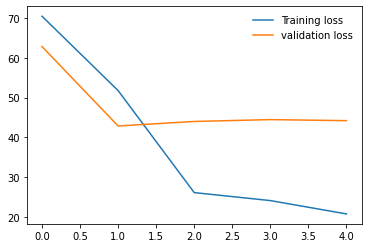

In [ ]:
from matplotlib import pyplot as plt

plt.plot(train_loss_data, label="Training loss")
plt.plot(valid_loss_data, label="validation loss")
plt.legend(frameon=False)

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
from google.colab import output
output.disable_custom_widget_manager()

In [ ]:
model2.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/Dataset/news_model2.pth", map_location = device))

<All keys matched successfully>

In [ ]:
all_preds = []
all_labels = []

for batch in test_dataloader:
    text, labels = batch
    inputs = tokenizer.batch_encode_plus(
        text, **tokenizer_config
    )
    input_ids = inputs['input_ids'].to(device)
    token_type_ids = inputs['token_type_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    labels = labels.to(device)

    # move things to model
    output = model2(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)
    preds = output.detach().cpu().numpy()
    preds = np.argmax(preds, axis = 1)
    all_preds.extend(preds)
    all_labels.extend(labels.cpu().numpy())

In [ ]:
from sklearn.metrics import classification_report

# preds = np.argmax(preds, axis = 1)
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.78      0.88      0.82         8
           1       0.86      0.75      0.80         8

    accuracy                           0.81        16
   macro avg       0.82      0.81      0.81        16
weighted avg       0.82      0.81      0.81        16



In [ ]:
print(model2.fc1.weight.data)

tensor([[ 0.0216, -0.0069,  0.0304,  ..., -0.0277, -0.0143,  0.0194],
        [ 0.0178, -0.0053,  0.0155,  ...,  0.0112, -0.0311,  0.0301],
        [-0.0281,  0.0259,  0.0119,  ...,  0.0284,  0.0286,  0.0031],
        ...,
        [-0.0004, -0.0241,  0.0303,  ...,  0.0052, -0.0110, -0.0290],
        [-0.0133,  0.0076, -0.0209,  ...,  0.0035, -0.0200,  0.0220],
        [-0.0223,  0.0311, -0.0276,  ...,  0.0062,  0.0172, -0.0005]],
       device='cuda:0')


In [ ]:
cf_matrix = confusion_matrix(all_labels, all_preds)  

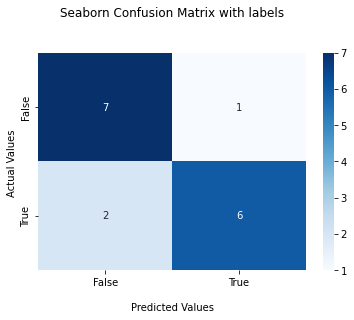

In [ ]:
import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score
test_accuracy5 = accuracy_score(all_labels, all_preds)
print('Accuracy: %.3f' % test_accuracy5)
precision5 = precision_score(all_labels, all_preds, average='macro')
print('Precision: %.3f' % precision5)
recall5 = recall_score(all_labels, all_preds, average='macro')
print('Recall: %.3f' % recall5)
score5 = f1_score(all_labels, all_preds, average='macro')
print('F-Measure: %.3f' % score5)

Accuracy: 0.812
Precision: 0.817
Recall: 0.812
F-Measure: 0.812


# For Looping

In [ ]:
if precision5 >= precision and recall5 >= recall and score5 >= score :
  torch.save(model2.state_dict(), "/content/drive/MyDrive/Colab Notebooks/Dataset/news_model1.pth")
  precision = precision5
  recall = recall5
  score = score5
  model.fc1.weight.data =model2.fc1.weight.data.clone()
  model.fc1.bias.data =model2.fc1.bias.data.clone()
  model.fc2.weight.data =model2.fc2.weight.data.clone()
  model.fc2.bias.data =model2.fc2.bias.data.clone()

# 6th Model


In [ ]:
class NewsDatasets(Dataset):
    def __init__(self, data, max_length=100):
        self.data = data
        
        self.config = {
            "max_length": max_length,
            "padding": "max_length",
            "return_tensors": "pt",
            "truncation": True,
            "add_special_tokens": True
        }

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        value = self.data.iloc[idx]
        return value['head']+"[SEP]"+value['con'] , value['label']

In [ ]:
auth = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dataset/For Sentiment /Division /40%/auth_set_6.csv",encoding='UTF-8')
fake = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dataset/For Sentiment /Division /40%/fake_set_6.csv",encoding='UTF-8')


print(len(auth))
print(len(fake))


1497
40


In [ ]:

#df = auth[:fake.shape[0]* 7]
df = auth.append(fake)
df = df.sample(frac=1).reset_index(drop=True)
len(df)

1537

In [ ]:
from bnlp import BasicTokenizer
from bnlp.corpus import stopwords, punctuations, letters, digits

btokenizer = BasicTokenizer()

def clean_text(text):
    tokens = btokenizer.tokenize(text)
    filtered = []
    for i in tokens:
        if i in stopwords:
            continue
    
        if i in punctuations + '‘' + '’':
            continue
    
        filtered.append(i)
    
    return " ".join(filtered)

print("********** Before ***************")
text = df.iloc[1]['content']
print(text)
print("\n********** After ***************")
print(clean_text(text))

********** Before ***************
﻿ঢাকা বিশ্ববিদ্যালয়ের ৫১তম সমাবর্তনে জাতীয় অধ্যাপক ড. আনিসুজ্জামান বলেছেন, উচ্চশিক্ষা লাভ করে শিক্ষার্থীরা যদি ভালোমন্দ বিচার করতে না পারে এবং ভালোর পক্ষে দাঁড়িয়ে মন্দকে প্রতিরোধ করতে না পারে তাহলে তাদের উচ্চশিক্ষা বৃথা। জীবনে আহরিত মূল্যবোধ সমাজের প্রচলিত মূল্যবোধ নাও হতে পারে। শিক্ষার্থীরা যদি মানুষের কল্যাণের লক্ষ্যে উত্তরাধিকারসূত্রে পাওয়া মূল্যবোধের বিরুদ্ধে বিদ্রোহ করে, সর্বাগ্রে তিনি তাকেই স্বাগত জানাবেন। অধ্যাপক আনিসুজ্জামান বলেন, আমাদের স্কুল-কলেজ-মাদ্রাসা যে হারে বৃদ্ধি পাচ্ছে, শিক্ষা বিস্তারের জন্য তা আবশ্যক। তবে এ ক্রমবর্ধমান বৃদ্ধির সঙ্গে তাল রেখে উপযুক্ত শিক্ষা পাওয়া যায় না। ফলে শিক্ষার্থীরা অনেক ক্ষেত্রে বিশেষত বাংলা ও ইংরেজি ভাষা শিক্ষার ক্ষেত্রে প্রার্থিত মানে উন্নীত হতে পারছে না। তারা যখন শিক্ষার তৃতীয় স্তরে অর্থাৎ উচ্চশিক্ষার ক্ষেত্রে প্রবেশ করে তখন এই দুর্বলতা আর দূর করার সুযোগ থাকে না। অবশ্য ১৯ শতকের শেষদিক থেকে বলা হতে থাকে, এ দেশে শিক্ষার মান অবনমন ঘটছে। তবে উচ্চশিক্ষার মানের অবনমন সম্পর্কে কর্মে নিয়োগকর্তারা এখন যেভাবে সমস্বরে ক

In [ ]:
undersample = RandomUnderSampler(sampling_strategy='majority')

In [ ]:
df['head'] = df.headline.apply(clean_text)
df['con'] = df.content.apply(clean_text)

In [ ]:
x= df.drop('label', axis=1)
y= df.label

In [ ]:
X_train_resampled, y_train_resampled = undersample.fit_resample(x, y)

In [ ]:
df = X_train_resampled.join(y_train_resampled)

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=121, stratify=df['label'])

In [ ]:
len(train_df), len(test_df)

(64, 16)

In [ ]:
training_data = NewsDatasets(train_df)
train_dataloader = DataLoader(training_data, batch_size=1, shuffle=True)

In [ ]:
test_data = NewsDatasets(test_df)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=True)

In [ ]:
class NewsBert2(nn.Module):

    def __init__(self, bert):
        super(NewsBert2, self).__init__()

        self.bert = bert

        # dropout layer
        self.dropout = nn.Dropout(0.2)

        # relu activation function
        self.relu = nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768, 128)

        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(128, 2)  

    # define the forward pass
    def forward(self, input_ids, token_type_ids, attention_mask):
        # pass the inputs to the model
        out = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

        x = self.fc1(out[1])
        x = self.relu(x)
        # output layer
        x = self.fc2(self.dropout(x))
        
        return x

In [ ]:
bert_model_name = "sagorsarker/bangla-bert-base"
bert = BertModel.from_pretrained(bert_model_name)
tokenizer = BertTokenizer.from_pretrained(bert_model_name)

Some weights of the model checkpoint at sagorsarker/bangla-bert-base were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2 = NewsBert(bert)
model2.to(device);

In [ ]:
from torch.optim.lr_scheduler import StepLR

optimizer = AdamW(model2.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

In [ ]:
model2.fc1.weight.data =model.fc1.weight.data.clone()
model2.fc1.bias.data =model.fc1.bias.data.clone()
model2.fc2.weight.data =model.fc2.weight.data.clone()
model2.fc2.bias.data =model.fc2.bias.data.clone()

In [ ]:
print(model2.fc1.weight.data)

tensor([[ 0.0216, -0.0073,  0.0304,  ..., -0.0277, -0.0146,  0.0193],
        [ 0.0180, -0.0051,  0.0156,  ...,  0.0111, -0.0308,  0.0300],
        [-0.0281,  0.0260,  0.0117,  ...,  0.0284,  0.0287,  0.0032],
        ...,
        [-0.0003, -0.0238,  0.0302,  ...,  0.0052, -0.0108, -0.0289],
        [-0.0134,  0.0074, -0.0208,  ...,  0.0035, -0.0201,  0.0218],
        [-0.0223,  0.0314, -0.0277,  ...,  0.0063,  0.0174, -0.0004]],
       device='cuda:0')


In [ ]:
def train(model, dataloader, optimizer, criterion, config):
    model2.train()  # prep model for training
    train_loss = 0
    for batch in tqdm(dataloader):
        text, labels = batch

        model2.zero_grad()

        inputs = tokenizer.batch_encode_plus(
            text, **config
        )
        input_ids = inputs['input_ids'].to(device)
        token_type_ids = inputs['token_type_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        # move things to model
        logs = model2(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)

        loss = criterion(logs, labels)
        train_loss += loss.item() * input_ids.size(0)
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        nn.utils.clip_grad_norm_(model2.parameters(), 1.0)
        optimizer.step()

    return train_loss

In [ ]:
def evaluate(model, dataloader, criterion, config):
    total = 0
    correct = 0
    valid_loss = 0.0

    model2.eval()  # prep model for evaluation
    for batch in dataloader:
        text, labels = batch
        inputs = tokenizer.batch_encode_plus(
            text, **config
        )
        input_ids = inputs['input_ids'].to(device)
        token_type_ids = inputs['token_type_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        # move things to model
        output = model2(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)

        loss_p = criterion(output, labels)
        # update running validation loss
        valid_loss += loss_p.item() * input_ids.size(0)
        # calculate accuracy
        proba = torch.exp(output)
        top_p, top_class = proba.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        # accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return total, correct, valid_loss

In [ ]:
epochs = 5
tokenizer_config = {
    "max_length": 100,
    "padding": "max_length",
    "return_tensors": "pt",
    "truncation": True,
    "add_special_tokens": True
}

In [ ]:
train_loss_data, valid_loss_data = [], []
valid_loss_min = np.Inf
since = time.time()
best_loss = np.inf

for epoch in range(epochs):
    print("Epoch: {}/{}".format(epoch + 1, epochs))
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    total = 0
    correct = 0
    e_since = time.time()

    # Train Model
    train_loss += train(model2, train_dataloader, optimizer, criterion, tokenizer_config)
    # Now Evaluate
    out = evaluate(model2, test_dataloader, criterion, tokenizer_config)
    total += out[0]
    correct += out[1]
    valid_loss += out[2]
    
    scheduler.step()

    # print training/validation statistics
    # calculate average loss over an epoch
    train_loss = train_loss / len(train_dataloader.dataset)
    valid_loss = valid_loss / len(test_dataloader.dataset)

    # calculate train loss and running loss
    train_loss_data.append(train_loss * 100)
    valid_loss_data.append(valid_loss * 100)
    
    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(model2.state_dict(), "/content/drive/MyDrive/Colab Notebooks/Dataset/news_model2.pth")

    print("\tTrain loss:{:.6f}..".format(train_loss),
          "\tValid Loss:{:.6f}..".format(valid_loss),
          "\tAccuracy: {:.4f}".format(correct / total * 100))

time_elapsed = time.time() - since
print('Training completed in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

Epoch: 1/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.673985.. 	Valid Loss:0.591196.. 	Accuracy: 75.0000
Epoch: 2/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.423909.. 	Valid Loss:0.392560.. 	Accuracy: 87.5000
Epoch: 3/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.180617.. 	Valid Loss:0.428993.. 	Accuracy: 81.2500
Epoch: 4/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.158241.. 	Valid Loss:0.437444.. 	Accuracy: 81.2500
Epoch: 5/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.149195.. 	Valid Loss:0.439256.. 	Accuracy: 81.2500
Training completed in 0m 47s


In [ ]:
training_acc6 = correct / total * 100
training_acc6

81.25

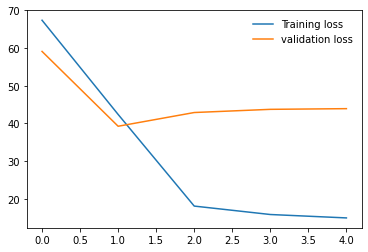

In [ ]:
from matplotlib import pyplot as plt

plt.plot(train_loss_data, label="Training loss")
plt.plot(valid_loss_data, label="validation loss")
plt.legend(frameon=False)

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
from google.colab import output
output.disable_custom_widget_manager()

In [ ]:
model2.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/Dataset/news_model2.pth", map_location = device))

<All keys matched successfully>

In [ ]:
all_preds = []
all_labels = []

for batch in test_dataloader:
    text, labels = batch
    inputs = tokenizer.batch_encode_plus(
        text, **tokenizer_config
    )
    input_ids = inputs['input_ids'].to(device)
    token_type_ids = inputs['token_type_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    labels = labels.to(device)

    # move things to model
    output = model2(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)
    preds = output.detach().cpu().numpy()
    preds = np.argmax(preds, axis = 1)
    all_preds.extend(preds)
    all_labels.extend(labels.cpu().numpy())

In [ ]:
from sklearn.metrics import classification_report

# preds = np.argmax(preds, axis = 1)
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       1.00      0.75      0.86         8
           1       0.80      1.00      0.89         8

    accuracy                           0.88        16
   macro avg       0.90      0.88      0.87        16
weighted avg       0.90      0.88      0.87        16



In [ ]:
print(model2.fc1.weight.data)

tensor([[ 0.0213, -0.0068,  0.0301,  ..., -0.0274, -0.0144,  0.0198],
        [ 0.0184, -0.0055,  0.0158,  ...,  0.0108, -0.0309,  0.0295],
        [-0.0285,  0.0255,  0.0121,  ...,  0.0284,  0.0282,  0.0029],
        ...,
        [-0.0003, -0.0242,  0.0304,  ...,  0.0051, -0.0111, -0.0293],
        [-0.0129,  0.0079, -0.0211,  ...,  0.0034, -0.0197,  0.0221],
        [-0.0227,  0.0309, -0.0273,  ...,  0.0063,  0.0170, -0.0008]],
       device='cuda:0')


In [ ]:
cf_matrix = confusion_matrix(all_labels, all_preds)  

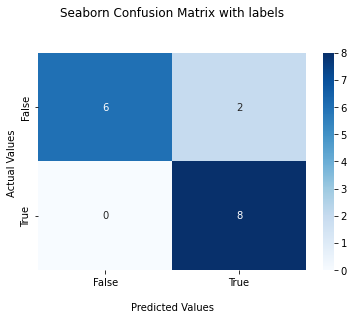

In [ ]:
import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score
test_accuracy6 = accuracy_score(all_labels, all_preds)
print('Accuracy: %.3f' % test_accuracy6)
precision6 = precision_score(all_labels, all_preds, average='macro')
print('Precision: %.3f' % precision6)
recall6 = recall_score(all_labels, all_preds, average='macro')
print('Recall: %.3f' % recall6)
score6 = f1_score(all_labels, all_preds, average='macro')
print('F-Measure: %.3f' % score6)

Accuracy: 0.875
Precision: 0.900
Recall: 0.875
F-Measure: 0.873


# For Looping

In [ ]:
if precision6 >= precision and recall6 >= recall and score6 >= score :
  torch.save(model2.state_dict(), "/content/drive/MyDrive/Colab Notebooks/Dataset/news_model1.pth")
  precision = precision6
  recall = recall6
  score = score6
  model.fc1.weight.data =model2.fc1.weight.data.clone()
  model.fc1.bias.data =model2.fc1.bias.data.clone()
  model.fc2.weight.data =model2.fc2.weight.data.clone()
  model.fc2.bias.data =model2.fc2.bias.data.clone()

# 7th Model


In [ ]:
class NewsDatasets(Dataset):
    def __init__(self, data, max_length=100):
        self.data = data
        
        self.config = {
            "max_length": max_length,
            "padding": "max_length",
            "return_tensors": "pt",
            "truncation": True,
            "add_special_tokens": True
        }

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        value = self.data.iloc[idx]
        return value['head']+"[SEP]"+value['con'] , value['label']

In [ ]:
auth = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dataset/For Sentiment /Division /40%/auth_set_7.csv",encoding='UTF-8')
fake = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dataset/For Sentiment /Division /40%/fake_set_7.csv",encoding='UTF-8')


print(len(auth))
print(len(fake))


1497
40


In [ ]:

#df = auth[:fake.shape[0]* 7]
df = auth.append(fake)
df = df.sample(frac=1).reset_index(drop=True)
len(df)

1537

In [ ]:
from bnlp import BasicTokenizer
from bnlp.corpus import stopwords, punctuations, letters, digits

btokenizer = BasicTokenizer()

def clean_text(text):
    tokens = btokenizer.tokenize(text)
    filtered = []
    for i in tokens:
        if i in stopwords:
            continue
    
        if i in punctuations + '‘' + '’':
            continue
    
        filtered.append(i)
    
    return " ".join(filtered)

print("********** Before ***************")
text = df.iloc[1]['content']
print(text)
print("\n********** After ***************")
print(clean_text(text))

********** Before ***************
বিএনপি-জামায়াতের সহিংসতায় গুরুতর আহত নেতাকর্মী, সাবেক খেলোয়াড়, অভিনেতা, সাহিত্যিকসহ ১২টি পরিবারকে ১ কোটি ৮২ লাখ টাকা অনুদান দিয়েছেন প্রধানমন্ত্রী শেখ হাসিনা। রোববার প্রধানমন্ত্রীর কার্যালয়ে এ চেক হস্তান্তর করেন তিনি। প্রধানমন্ত্রীর কাছ থেকে চেক গ্রহণ করেন প্রয়াত ফুটবলার মোনেম মুন্নার স্ত্রী ইয়াসমিন মুন্না, হকি খেলোয়াড় জাহিদুর রহমান পুশকিনের স্ত্রী ফাহমিদা রহমান এবং জুম্মন লুসাইয়ের স্ত্রী পুইই লুসাই, অভিনেতা সারওয়ার উদ্দিন ড্যানীরাজ, কবি ও আলোকচিত্রী বিল্লাল হোসেন, ফটিকছড়ি বিএনপি জামাতের সহিংসতায় আহত জামাল পাশা এবং চাঁপাইনবাবগঞ্জের নূরজাহান প্রমুখ। প্রধানমন্ত্রীর ত্রাণ তহবিল থেকে তাদের চিকিৎসা ও ভরণপোষণের জন্য এ অনুদান দেন শেখ হাসিনা। এইউএ/এনডিএস/জেআইএম

********** After ***************
বিএনপি জামায়াতের সহিংসতায় গুরুতর আহত নেতাকর্মী সাবেক খেলোয়াড় অভিনেতা সাহিত্যিকসহ ১২টি পরিবারকে ১ ৮২ লাখ টাকা অনুদান দিয়েছেন প্রধানমন্ত্রী শেখ হাসিনা রোববার প্রধানমন্ত্রীর কার্যালয়ে চেক হস্তান্তর প্রধানমন্ত্রীর চেক গ্রহণ প্রয়াত ফুটবলার মোনেম মুন্নার স্ত্রী ইয়াসমিন মুন্না 

In [ ]:
undersample = RandomUnderSampler(sampling_strategy='majority')

In [ ]:
df['head'] = df.headline.apply(clean_text)
df['con'] = df.content.apply(clean_text)

In [ ]:
x= df.drop('label', axis=1)
y= df.label

In [ ]:
X_train_resampled, y_train_resampled = undersample.fit_resample(x, y)

In [ ]:
df = X_train_resampled.join(y_train_resampled)

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=121, stratify=df['label'])

In [ ]:
len(train_df), len(test_df)

(64, 16)

In [ ]:
training_data = NewsDatasets(train_df)
train_dataloader = DataLoader(training_data, batch_size=1, shuffle=True)

In [ ]:
test_data = NewsDatasets(test_df)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=True)

In [ ]:
class NewsBert2(nn.Module):

    def __init__(self, bert):
        super(NewsBert2, self).__init__()

        self.bert = bert

        # dropout layer
        self.dropout = nn.Dropout(0.2)

        # relu activation function
        self.relu = nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768, 128)

        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(128, 2)  

    # define the forward pass
    def forward(self, input_ids, token_type_ids, attention_mask):
        # pass the inputs to the model
        out = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

        x = self.fc1(out[1])
        x = self.relu(x)
        # output layer
        x = self.fc2(self.dropout(x))
        
        return x

In [ ]:
bert_model_name = "sagorsarker/bangla-bert-base"
bert = BertModel.from_pretrained(bert_model_name)
tokenizer = BertTokenizer.from_pretrained(bert_model_name)

Some weights of the model checkpoint at sagorsarker/bangla-bert-base were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2 = NewsBert(bert)
model2.to(device);

In [ ]:
from torch.optim.lr_scheduler import StepLR

optimizer = AdamW(model2.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

In [ ]:
model2.fc1.weight.data =model.fc1.weight.data.clone()
model2.fc1.bias.data =model.fc1.bias.data.clone()
model2.fc2.weight.data =model.fc2.weight.data.clone()
model2.fc2.bias.data =model.fc2.bias.data.clone()

In [ ]:
print(model2.fc1.weight.data)

tensor([[ 0.0213, -0.0068,  0.0301,  ..., -0.0274, -0.0144,  0.0198],
        [ 0.0184, -0.0055,  0.0158,  ...,  0.0108, -0.0309,  0.0295],
        [-0.0285,  0.0255,  0.0121,  ...,  0.0284,  0.0282,  0.0029],
        ...,
        [-0.0003, -0.0242,  0.0304,  ...,  0.0051, -0.0111, -0.0293],
        [-0.0129,  0.0079, -0.0211,  ...,  0.0034, -0.0197,  0.0221],
        [-0.0227,  0.0309, -0.0273,  ...,  0.0063,  0.0170, -0.0008]],
       device='cuda:0')


In [ ]:
def train(model, dataloader, optimizer, criterion, config):
    model2.train()  # prep model for training
    train_loss = 0
    for batch in tqdm(dataloader):
        text, labels = batch

        model2.zero_grad()

        inputs = tokenizer.batch_encode_plus(
            text, **config
        )
        input_ids = inputs['input_ids'].to(device)
        token_type_ids = inputs['token_type_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        # move things to model
        logs = model2(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)

        loss = criterion(logs, labels)
        train_loss += loss.item() * input_ids.size(0)
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        nn.utils.clip_grad_norm_(model2.parameters(), 1.0)
        optimizer.step()

    return train_loss

In [ ]:
def evaluate(model, dataloader, criterion, config):
    total = 0
    correct = 0
    valid_loss = 0.0

    model2.eval()  # prep model for evaluation
    for batch in dataloader:
        text, labels = batch
        inputs = tokenizer.batch_encode_plus(
            text, **config
        )
        input_ids = inputs['input_ids'].to(device)
        token_type_ids = inputs['token_type_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        # move things to model
        output = model2(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)

        loss_p = criterion(output, labels)
        # update running validation loss
        valid_loss += loss_p.item() * input_ids.size(0)
        # calculate accuracy
        proba = torch.exp(output)
        top_p, top_class = proba.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        # accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return total, correct, valid_loss

In [ ]:
epochs = 5
tokenizer_config = {
    "max_length": 100,
    "padding": "max_length",
    "return_tensors": "pt",
    "truncation": True,
    "add_special_tokens": True
}

In [ ]:
train_loss_data, valid_loss_data = [], []
valid_loss_min = np.Inf
since = time.time()
best_loss = np.inf

for epoch in range(epochs):
    print("Epoch: {}/{}".format(epoch + 1, epochs))
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    total = 0
    correct = 0
    e_since = time.time()

    # Train Model
    train_loss += train(model2, train_dataloader, optimizer, criterion, tokenizer_config)
    # Now Evaluate
    out = evaluate(model2, test_dataloader, criterion, tokenizer_config)
    total += out[0]
    correct += out[1]
    valid_loss += out[2]
    
    scheduler.step()

    # print training/validation statistics
    # calculate average loss over an epoch
    train_loss = train_loss / len(train_dataloader.dataset)
    valid_loss = valid_loss / len(test_dataloader.dataset)

    # calculate train loss and running loss
    train_loss_data.append(train_loss * 100)
    valid_loss_data.append(valid_loss * 100)
    
    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(model2.state_dict(), "/content/drive/MyDrive/Colab Notebooks/Dataset/news_model2.pth")

    print("\tTrain loss:{:.6f}..".format(train_loss),
          "\tValid Loss:{:.6f}..".format(valid_loss),
          "\tAccuracy: {:.4f}".format(correct / total * 100))

time_elapsed = time.time() - since
print('Training completed in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

Epoch: 1/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.748947.. 	Valid Loss:0.633062.. 	Accuracy: 68.7500
Epoch: 2/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.455567.. 	Valid Loss:0.575374.. 	Accuracy: 68.7500
Epoch: 3/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.208790.. 	Valid Loss:0.570282.. 	Accuracy: 68.7500
Epoch: 4/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.189712.. 	Valid Loss:0.573888.. 	Accuracy: 68.7500
Epoch: 5/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.167148.. 	Valid Loss:0.563308.. 	Accuracy: 75.0000
Training completed in 0m 51s


In [ ]:
training_acc7 = correct / total * 100
training_acc7

75.0

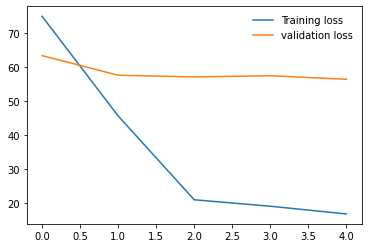

In [ ]:
from matplotlib import pyplot as plt

plt.plot(train_loss_data, label="Training loss")
plt.plot(valid_loss_data, label="validation loss")
plt.legend(frameon=False)

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
from google.colab import output
output.disable_custom_widget_manager()

In [ ]:
model2.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/Dataset/news_model2.pth", map_location = device))

<All keys matched successfully>

In [ ]:
all_preds = []
all_labels = []

for batch in test_dataloader:
    text, labels = batch
    inputs = tokenizer.batch_encode_plus(
        text, **tokenizer_config
    )
    input_ids = inputs['input_ids'].to(device)
    token_type_ids = inputs['token_type_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    labels = labels.to(device)

    # move things to model
    output = model2(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)
    preds = output.detach().cpu().numpy()
    preds = np.argmax(preds, axis = 1)
    all_preds.extend(preds)
    all_labels.extend(labels.cpu().numpy())

In [ ]:
from sklearn.metrics import classification_report

# preds = np.argmax(preds, axis = 1)
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.70      0.88      0.78         8
           1       0.83      0.62      0.71         8

    accuracy                           0.75        16
   macro avg       0.77      0.75      0.75        16
weighted avg       0.77      0.75      0.75        16



In [ ]:
print(model2.fc1.weight.data)

tensor([[ 0.0211, -0.0063,  0.0299,  ..., -0.0276, -0.0142,  0.0200],
        [ 0.0183, -0.0057,  0.0159,  ...,  0.0109, -0.0310,  0.0293],
        [-0.0288,  0.0252,  0.0126,  ...,  0.0282,  0.0279,  0.0024],
        ...,
        [-0.0005, -0.0247,  0.0308,  ...,  0.0051, -0.0114, -0.0295],
        [-0.0125,  0.0083, -0.0214,  ...,  0.0035, -0.0193,  0.0225],
        [-0.0230,  0.0304, -0.0269,  ...,  0.0063,  0.0166, -0.0011]],
       device='cuda:0')


In [ ]:
cf_matrix = confusion_matrix(all_labels, all_preds)  

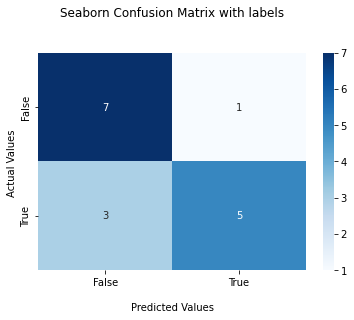

In [ ]:
import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score
test_accuracy7 = accuracy_score(all_labels, all_preds)
print('Accuracy: %.3f' % test_accuracy7)
precision7 = precision_score(all_labels, all_preds, average='macro')
print('Precision: %.3f' % precision7)
recall7 = recall_score(all_labels, all_preds, average='macro')
print('Recall: %.3f' % recall7)
score7 = f1_score(all_labels, all_preds, average='macro')
print('F-Measure: %.3f' % score7)

Accuracy: 0.750
Precision: 0.767
Recall: 0.750
F-Measure: 0.746


# For Looping

In [ ]:
if precision7 >= precision and recall7 >= recall and score7 >= score :
  torch.save(model2.state_dict(), "/content/drive/MyDrive/Colab Notebooks/Dataset/news_model1.pth")
  precision = precision7
  recall = recall7
  score = score7
  model.fc1.weight.data =model2.fc1.weight.data.clone()
  model.fc1.bias.data =model2.fc1.bias.data.clone()
  model.fc2.weight.data =model2.fc2.weight.data.clone()
  model.fc2.bias.data =model2.fc2.bias.data.clone()

# 8th Model


In [ ]:
class NewsDatasets(Dataset):
    def __init__(self, data, max_length=100):
        self.data = data
        
        self.config = {
            "max_length": max_length,
            "padding": "max_length",
            "return_tensors": "pt",
            "truncation": True,
            "add_special_tokens": True
        }

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        value = self.data.iloc[idx]
        return value['head']+"[SEP]"+value['con'] , value['label']

In [ ]:
auth = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dataset/For Sentiment /Division /40%/auth_set_8.csv",encoding='UTF-8')
fake = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dataset/For Sentiment /Division /40%/fake_set_8.csv",encoding='UTF-8')


print(len(auth))
print(len(fake))


1497
40


In [ ]:

#df = auth[:fake.shape[0]* 7]
df = auth.append(fake)
df = df.sample(frac=1).reset_index(drop=True)
len(df)

1537

In [ ]:
from bnlp import BasicTokenizer
from bnlp.corpus import stopwords, punctuations, letters, digits

btokenizer = BasicTokenizer()

def clean_text(text):
    tokens = btokenizer.tokenize(text)
    filtered = []
    for i in tokens:
        if i in stopwords:
            continue
    
        if i in punctuations + '‘' + '’':
            continue
    
        filtered.append(i)
    
    return " ".join(filtered)

print("********** Before ***************")
text = df.iloc[1]['content']
print(text)
print("\n********** After ***************")
print(clean_text(text))

********** Before ***************
নিজের বানানো মিউজিক ভিডিও দিয়ে সোশ্যাল মিডিয়ায় বেশ আলোচনায় উঠে আসেন বগুড়ার ছেলে হিরো আলম। সোশ্যাল মিডিয়ার ভাইরাল হওয়ার পর চলে আসেন ঢাকায়। অভিনয় করতে শুরু করেন স্বল্প দৈর্ঘ্য চলচ্চিত্রে। অভিনয় করেছেন বড় পর্দাতেও। সম্প্রতি অভিনয়ের জন্য চুক্তিবদ্ধ হয়েছেন বলিউডের চলচ্চিত্রে। আসন্ন জাতীয় সংসদ নির্বাচনে অংশ নিতে যাচ্ছেন তিনি। নির্বাচন, বলিউডে কাজ করাসহ সমসাময়িক নানা বিষয় নিয়ে বিডি২৪লাইভের সাথে কথা হয় হিরো আলমের। তার চুম্বক অংশ পাঠকদের জন্য তুলে ধরা হল- বিডি২৪লাইভঃ হুট করেই সংসদ নির্বাচনে অংশ নেয়ার সিদ্ধান্ত কেন? হিরো আলমঃ আপনারা হয়তো জানেন আমি এলাকাতে দুইবার ইউপি নির্বাচন করেছি। তখন আমাকে শুধু এলাকার মানুষ চিনতো। এখন আপনাদের দোয়া আর ভালোবাসায় সারা বাংলাদেশের মানুষ আমাকে চিনে। আর সবার ভালোবাসা নিয়েই সংসদ নির্বাচনে অংশ নিতে যাচ্ছি। বিডি২৪লাইভঃ কোন দল থেকে নির্বাচন করবেন? হিরো আলমঃ এখন পর্যন্ত কোন সিদ্ধান্ত নেই নাই। অনেকেই ডাকছে কিন্তু আমি এখনো কিছু জানাই নাই কারণ আমি চাই স্বতন্ত্র থেকে নির্বাচন করতে। বিডি২৪লাইভঃ বলিউডের সিনেমার কি অবস্থা? হিরো আলমঃ ডিসেম্বরে শ

In [ ]:
undersample = RandomUnderSampler(sampling_strategy='majority')

In [ ]:
df['head'] = df.headline.apply(clean_text)
df['con'] = df.content.apply(clean_text)

In [ ]:
x= df.drop('label', axis=1)
y= df.label

In [ ]:
X_train_resampled, y_train_resampled = undersample.fit_resample(x, y)

In [ ]:
df = X_train_resampled.join(y_train_resampled)

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=121, stratify=df['label'])

In [ ]:
len(train_df), len(test_df)

(64, 16)

In [ ]:
training_data = NewsDatasets(train_df)
train_dataloader = DataLoader(training_data, batch_size=1, shuffle=True)

In [ ]:
test_data = NewsDatasets(test_df)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=True)

In [ ]:
class NewsBert2(nn.Module):

    def __init__(self, bert):
        super(NewsBert2, self).__init__()

        self.bert = bert

        # dropout layer
        self.dropout = nn.Dropout(0.2)

        # relu activation function
        self.relu = nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768, 128)

        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(128, 2)  

    # define the forward pass
    def forward(self, input_ids, token_type_ids, attention_mask):
        # pass the inputs to the model
        out = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

        x = self.fc1(out[1])
        x = self.relu(x)
        # output layer
        x = self.fc2(self.dropout(x))
        
        return x

In [ ]:
bert_model_name = "sagorsarker/bangla-bert-base"
bert = BertModel.from_pretrained(bert_model_name)
tokenizer = BertTokenizer.from_pretrained(bert_model_name)

Some weights of the model checkpoint at sagorsarker/bangla-bert-base were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2 = NewsBert(bert)
model2.to(device);

In [ ]:
from torch.optim.lr_scheduler import StepLR

optimizer = AdamW(model2.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

In [ ]:
model2.fc1.weight.data =model.fc1.weight.data.clone()
model2.fc1.bias.data =model.fc1.bias.data.clone()
model2.fc2.weight.data =model.fc2.weight.data.clone()
model2.fc2.bias.data =model.fc2.bias.data.clone()

In [ ]:
print(model2.fc1.weight.data)

tensor([[ 0.0213, -0.0068,  0.0301,  ..., -0.0274, -0.0144,  0.0198],
        [ 0.0184, -0.0055,  0.0158,  ...,  0.0108, -0.0309,  0.0295],
        [-0.0285,  0.0255,  0.0121,  ...,  0.0284,  0.0282,  0.0029],
        ...,
        [-0.0003, -0.0242,  0.0304,  ...,  0.0051, -0.0111, -0.0293],
        [-0.0129,  0.0079, -0.0211,  ...,  0.0034, -0.0197,  0.0221],
        [-0.0227,  0.0309, -0.0273,  ...,  0.0063,  0.0170, -0.0008]],
       device='cuda:0')


In [ ]:
def train(model, dataloader, optimizer, criterion, config):
    model2.train()  # prep model for training
    train_loss = 0
    for batch in tqdm(dataloader):
        text, labels = batch

        model2.zero_grad()

        inputs = tokenizer.batch_encode_plus(
            text, **config
        )
        input_ids = inputs['input_ids'].to(device)
        token_type_ids = inputs['token_type_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        # move things to model
        logs = model2(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)

        loss = criterion(logs, labels)
        train_loss += loss.item() * input_ids.size(0)
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        nn.utils.clip_grad_norm_(model2.parameters(), 1.0)
        optimizer.step()

    return train_loss

In [ ]:
def evaluate(model, dataloader, criterion, config):
    total = 0
    correct = 0
    valid_loss = 0.0

    model2.eval()  # prep model for evaluation
    for batch in dataloader:
        text, labels = batch
        inputs = tokenizer.batch_encode_plus(
            text, **config
        )
        input_ids = inputs['input_ids'].to(device)
        token_type_ids = inputs['token_type_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        # move things to model
        output = model2(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)

        loss_p = criterion(output, labels)
        # update running validation loss
        valid_loss += loss_p.item() * input_ids.size(0)
        # calculate accuracy
        proba = torch.exp(output)
        top_p, top_class = proba.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        # accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return total, correct, valid_loss

In [ ]:
epochs = 5
tokenizer_config = {
    "max_length": 100,
    "padding": "max_length",
    "return_tensors": "pt",
    "truncation": True,
    "add_special_tokens": True
}

In [ ]:
train_loss_data, valid_loss_data = [], []
valid_loss_min = np.Inf
since = time.time()
best_loss = np.inf

for epoch in range(epochs):
    print("Epoch: {}/{}".format(epoch + 1, epochs))
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    total = 0
    correct = 0
    e_since = time.time()

    # Train Model
    train_loss += train(model2, train_dataloader, optimizer, criterion, tokenizer_config)
    # Now Evaluate
    out = evaluate(model2, test_dataloader, criterion, tokenizer_config)
    total += out[0]
    correct += out[1]
    valid_loss += out[2]
    
    scheduler.step()

    # print training/validation statistics
    # calculate average loss over an epoch
    train_loss = train_loss / len(train_dataloader.dataset)
    valid_loss = valid_loss / len(test_dataloader.dataset)

    # calculate train loss and running loss
    train_loss_data.append(train_loss * 100)
    valid_loss_data.append(valid_loss * 100)
    
    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(model2.state_dict(), "/content/drive/MyDrive/Colab Notebooks/Dataset/news_model2.pth")

    print("\tTrain loss:{:.6f}..".format(train_loss),
          "\tValid Loss:{:.6f}..".format(valid_loss),
          "\tAccuracy: {:.4f}".format(correct / total * 100))

time_elapsed = time.time() - since
print('Training completed in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

Epoch: 1/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.736150.. 	Valid Loss:0.737850.. 	Accuracy: 56.2500
Epoch: 2/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.423446.. 	Valid Loss:0.926221.. 	Accuracy: 56.2500
Epoch: 3/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.149549.. 	Valid Loss:0.665148.. 	Accuracy: 75.0000
Epoch: 4/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.093787.. 	Valid Loss:0.680993.. 	Accuracy: 81.2500
Epoch: 5/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.079559.. 	Valid Loss:0.678488.. 	Accuracy: 81.2500
Training completed in 0m 45s


In [ ]:
training_acc8 = correct / total * 100
training_acc8

81.25

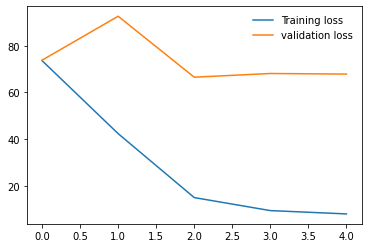

In [ ]:
from matplotlib import pyplot as plt

plt.plot(train_loss_data, label="Training loss")
plt.plot(valid_loss_data, label="validation loss")
plt.legend(frameon=False)

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
from google.colab import output
output.disable_custom_widget_manager()

In [ ]:
model2.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/Dataset/news_model2.pth", map_location = device))

<All keys matched successfully>

In [ ]:
all_preds = []
all_labels = []

for batch in test_dataloader:
    text, labels = batch
    inputs = tokenizer.batch_encode_plus(
        text, **tokenizer_config
    )
    input_ids = inputs['input_ids'].to(device)
    token_type_ids = inputs['token_type_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    labels = labels.to(device)

    # move things to model
    output = model2(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)
    preds = output.detach().cpu().numpy()
    preds = np.argmax(preds, axis = 1)
    all_preds.extend(preds)
    all_labels.extend(labels.cpu().numpy())

In [ ]:
from sklearn.metrics import classification_report

# preds = np.argmax(preds, axis = 1)
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       1.00      0.50      0.67         8
           1       0.67      1.00      0.80         8

    accuracy                           0.75        16
   macro avg       0.83      0.75      0.73        16
weighted avg       0.83      0.75      0.73        16



In [ ]:
print(model2.fc1.weight.data)

tensor([[ 0.0209, -0.0065,  0.0298,  ..., -0.0273, -0.0141,  0.0202],
        [ 0.0185, -0.0056,  0.0159,  ...,  0.0108, -0.0310,  0.0293],
        [-0.0288,  0.0251,  0.0125,  ...,  0.0285,  0.0279,  0.0023],
        ...,
        [-0.0005, -0.0248,  0.0308,  ...,  0.0051, -0.0116, -0.0296],
        [-0.0124,  0.0084, -0.0215,  ...,  0.0032, -0.0192,  0.0224],
        [-0.0229,  0.0304, -0.0269,  ...,  0.0064,  0.0165, -0.0011]],
       device='cuda:0')


In [ ]:
cf_matrix = confusion_matrix(all_labels, all_preds)  

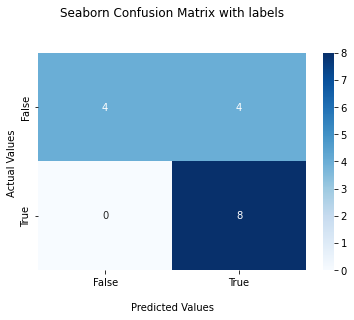

In [ ]:
import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score
test_accuracy8 = accuracy_score(all_labels, all_preds)
print('Accuracy: %.3f' % test_accuracy8)
precision8 = precision_score(all_labels, all_preds, average='macro')
print('Precision: %.3f' % precision8)
recall8 = recall_score(all_labels, all_preds, average='macro')
print('Recall: %.3f' % recall8)
score8 = f1_score(all_labels, all_preds, average='macro')
print('F-Measure: %.3f' % score8)

Accuracy: 0.750
Precision: 0.833
Recall: 0.750
F-Measure: 0.733


# For Looping

In [ ]:
if precision8 >= precision and recall8 >= recall and score8 >= score :
  torch.save(model2.state_dict(), "/content/drive/MyDrive/Colab Notebooks/Dataset/news_model1.pth")
  precision = precision8
  recall = recall8
  score = score8
  model.fc1.weight.data =model2.fc1.weight.data.clone()
  model.fc1.bias.data =model2.fc1.bias.data.clone()
  model.fc2.weight.data =model2.fc2.weight.data.clone()
  model.fc2.bias.data =model2.fc2.bias.data.clone()

# 9th Model


In [ ]:
class NewsDatasets(Dataset):
    def __init__(self, data, max_length=100):
        self.data = data
        
        self.config = {
            "max_length": max_length,
            "padding": "max_length",
            "return_tensors": "pt",
            "truncation": True,
            "add_special_tokens": True
        }

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        value = self.data.iloc[idx]
        return value['head']+"[SEP]"+value['con'] , value['label']

In [ ]:
auth = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dataset/For Sentiment /Division /40%/auth_set_9.csv",encoding='UTF-8')
fake = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dataset/For Sentiment /Division /40%/fake_set_9.csv",encoding='UTF-8')


print(len(auth))
print(len(fake))


1497
40


In [ ]:

#df = auth[:fake.shape[0]* 7]
df = auth.append(fake)
df = df.sample(frac=1).reset_index(drop=True)
len(df)

1537

In [ ]:
from bnlp import BasicTokenizer
from bnlp.corpus import stopwords, punctuations, letters, digits

btokenizer = BasicTokenizer()

def clean_text(text):
    tokens = btokenizer.tokenize(text)
    filtered = []
    for i in tokens:
        if i in stopwords:
            continue
    
        if i in punctuations + '‘' + '’':
            continue
    
        filtered.append(i)
    
    return " ".join(filtered)

print("********** Before ***************")
text = df.iloc[1]['content']
print(text)
print("\n********** After ***************")
print(clean_text(text))

********** Before ***************
সরকার ক্ষমতা সুরক্ষিত করতে ডিজিটাল নিরাপত্তা আইন-২০১৮ পাস করেছে বলে দাবি করেছে বিএনপি।   সোমবার (০৮ অক্টোবর) রাজধানীর একটি হোটেলে মতবিনিময় সভায় এ দাবি করেন নেতারা। তারা বলেন, মুক্তিযুদ্ধের স্বপ্ন নস্যাৎ করতেই কালো আইন করেছে সরকার। বিএনপির স্থায়ী কমিটির সদস্য আমীর খসরু মাহমুদ চৌধুরী বলেন, ‘(সরকার) ওনাদের একটি নির্বাচনী প্রকল্প আছে। যে প্রকল্পটার মধ্যে নির্বাচনী প্রকল্পের অংশ হিসেবে এ আইনটি করা হয়েছে। এই প্রকল্পের মধ্যে আছে ইভিএম, এই প্রকল্পের মধ্যে রয়েছে দলীয় নির্বাচন কমিশন।’   অন্যদিকে মির্জা ফখরুল ইসলাম বলেন, ‘অত্যন্ত দুর্ভাগ্যের বিষয় ১৯৭১ সালে আমরা মুক্তিযুদ্ধ করি। সেই যুদ্ধের আগে পরে আমরা যে স্বপ্ন দেখেছিলাম। আর এই স্বপ্নটিকে ১৯৭২ সালে যারা ক্ষমতায় ছিলেন এবং আজ যারা ক্ষমতায় আছে, তারা প্রতিটি স্বপ্নকে শেষ করে দিয়েছে।’

********** After ***************
সরকার ক্ষমতা সুরক্ষিত ডিজিটাল নিরাপত্তা আইন ২০১৮ পাস দাবি বিএনপি সোমবার ০৮ অক্টোবর রাজধানীর হোটেলে মতবিনিময় সভায় দাবি নেতারা মুক্তিযুদ্ধের স্বপ্ন নস্যাৎ করতেই কালো আইন সরকার বিএনপির স্থায়ী কমিটির সদস্য 

In [ ]:
undersample = RandomUnderSampler(sampling_strategy='majority')

In [ ]:
df['head'] = df.headline.apply(clean_text)
df['con'] = df.content.apply(clean_text)

In [ ]:
x= df.drop('label', axis=1)
y= df.label

In [ ]:
X_train_resampled, y_train_resampled = undersample.fit_resample(x, y)

In [ ]:
df = X_train_resampled.join(y_train_resampled)

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=121, stratify=df['label'])

In [ ]:
len(train_df), len(test_df)

(64, 16)

In [ ]:
training_data = NewsDatasets(train_df)
train_dataloader = DataLoader(training_data, batch_size=1, shuffle=True)

In [ ]:
test_data = NewsDatasets(test_df)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=True)

In [ ]:
class NewsBert2(nn.Module):

    def __init__(self, bert):
        super(NewsBert2, self).__init__()

        self.bert = bert

        # dropout layer
        self.dropout = nn.Dropout(0.2)

        # relu activation function
        self.relu = nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768, 128)

        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(128, 2)  

    # define the forward pass
    def forward(self, input_ids, token_type_ids, attention_mask):
        # pass the inputs to the model
        out = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

        x = self.fc1(out[1])
        x = self.relu(x)
        # output layer
        x = self.fc2(self.dropout(x))
        
        return x

In [ ]:
bert_model_name = "sagorsarker/bangla-bert-base"
bert = BertModel.from_pretrained(bert_model_name)
tokenizer = BertTokenizer.from_pretrained(bert_model_name)

Some weights of the model checkpoint at sagorsarker/bangla-bert-base were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2 = NewsBert(bert)
model2.to(device);

In [ ]:
from torch.optim.lr_scheduler import StepLR

optimizer = AdamW(model2.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

In [ ]:
model2.fc1.weight.data =model.fc1.weight.data.clone()
model2.fc1.bias.data =model.fc1.bias.data.clone()
model2.fc2.weight.data =model.fc2.weight.data.clone()
model2.fc2.bias.data =model.fc2.bias.data.clone()

In [ ]:
print(model2.fc1.weight.data)

tensor([[ 0.0213, -0.0068,  0.0301,  ..., -0.0274, -0.0144,  0.0198],
        [ 0.0184, -0.0055,  0.0158,  ...,  0.0108, -0.0309,  0.0295],
        [-0.0285,  0.0255,  0.0121,  ...,  0.0284,  0.0282,  0.0029],
        ...,
        [-0.0003, -0.0242,  0.0304,  ...,  0.0051, -0.0111, -0.0293],
        [-0.0129,  0.0079, -0.0211,  ...,  0.0034, -0.0197,  0.0221],
        [-0.0227,  0.0309, -0.0273,  ...,  0.0063,  0.0170, -0.0008]],
       device='cuda:0')


In [ ]:
def train(model, dataloader, optimizer, criterion, config):
    model2.train()  # prep model for training
    train_loss = 0
    for batch in tqdm(dataloader):
        text, labels = batch

        model2.zero_grad()

        inputs = tokenizer.batch_encode_plus(
            text, **config
        )
        input_ids = inputs['input_ids'].to(device)
        token_type_ids = inputs['token_type_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        # move things to model
        logs = model2(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)

        loss = criterion(logs, labels)
        train_loss += loss.item() * input_ids.size(0)
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        nn.utils.clip_grad_norm_(model2.parameters(), 1.0)
        optimizer.step()

    return train_loss

In [ ]:
def evaluate(model, dataloader, criterion, config):
    total = 0
    correct = 0
    valid_loss = 0.0

    model2.eval()  # prep model for evaluation
    for batch in dataloader:
        text, labels = batch
        inputs = tokenizer.batch_encode_plus(
            text, **config
        )
        input_ids = inputs['input_ids'].to(device)
        token_type_ids = inputs['token_type_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        # move things to model
        output = model2(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)

        loss_p = criterion(output, labels)
        # update running validation loss
        valid_loss += loss_p.item() * input_ids.size(0)
        # calculate accuracy
        proba = torch.exp(output)
        top_p, top_class = proba.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        # accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return total, correct, valid_loss

In [ ]:
epochs = 5
tokenizer_config = {
    "max_length": 100,
    "padding": "max_length",
    "return_tensors": "pt",
    "truncation": True,
    "add_special_tokens": True
}

In [ ]:
train_loss_data, valid_loss_data = [], []
valid_loss_min = np.Inf
since = time.time()
best_loss = np.inf

for epoch in range(epochs):
    print("Epoch: {}/{}".format(epoch + 1, epochs))
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    total = 0
    correct = 0
    e_since = time.time()

    # Train Model
    train_loss += train(model2, train_dataloader, optimizer, criterion, tokenizer_config)
    # Now Evaluate
    out = evaluate(model2, test_dataloader, criterion, tokenizer_config)
    total += out[0]
    correct += out[1]
    valid_loss += out[2]
    
    scheduler.step()

    # print training/validation statistics
    # calculate average loss over an epoch
    train_loss = train_loss / len(train_dataloader.dataset)
    valid_loss = valid_loss / len(test_dataloader.dataset)

    # calculate train loss and running loss
    train_loss_data.append(train_loss * 100)
    valid_loss_data.append(valid_loss * 100)
    
    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(model2.state_dict(), "/content/drive/MyDrive/Colab Notebooks/Dataset/news_model2.pth")

    print("\tTrain loss:{:.6f}..".format(train_loss),
          "\tValid Loss:{:.6f}..".format(valid_loss),
          "\tAccuracy: {:.4f}".format(correct / total * 100))

time_elapsed = time.time() - since
print('Training completed in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

Epoch: 1/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.635697.. 	Valid Loss:0.395276.. 	Accuracy: 87.5000
Epoch: 2/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.191897.. 	Valid Loss:0.300770.. 	Accuracy: 87.5000
Epoch: 3/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.055668.. 	Valid Loss:0.258577.. 	Accuracy: 93.7500
Epoch: 4/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.041891.. 	Valid Loss:0.261369.. 	Accuracy: 93.7500
Epoch: 5/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.037552.. 	Valid Loss:0.261250.. 	Accuracy: 93.7500
Training completed in 0m 46s


In [ ]:
training_acc9 = correct / total * 100
training_acc9

93.75

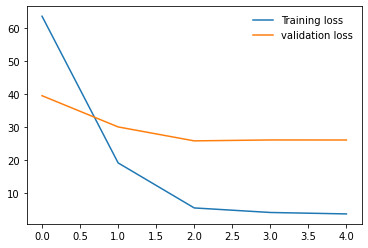

In [ ]:
from matplotlib import pyplot as plt

plt.plot(train_loss_data, label="Training loss")
plt.plot(valid_loss_data, label="validation loss")
plt.legend(frameon=False)

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
from google.colab import output
output.disable_custom_widget_manager()

In [ ]:
model2.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/Dataset/news_model2.pth", map_location = device))

<All keys matched successfully>

In [ ]:
all_preds = []
all_labels = []

for batch in test_dataloader:
    text, labels = batch
    inputs = tokenizer.batch_encode_plus(
        text, **tokenizer_config
    )
    input_ids = inputs['input_ids'].to(device)
    token_type_ids = inputs['token_type_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    labels = labels.to(device)

    # move things to model
    output = model2(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)
    preds = output.detach().cpu().numpy()
    preds = np.argmax(preds, axis = 1)
    all_preds.extend(preds)
    all_labels.extend(labels.cpu().numpy())

In [ ]:
from sklearn.metrics import classification_report

# preds = np.argmax(preds, axis = 1)
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94         8
           1       1.00      0.88      0.93         8

    accuracy                           0.94        16
   macro avg       0.94      0.94      0.94        16
weighted avg       0.94      0.94      0.94        16



In [ ]:
print(model2.fc1.weight.data)

tensor([[ 0.0214, -0.0063,  0.0298,  ..., -0.0273, -0.0140,  0.0203],
        [ 0.0182, -0.0057,  0.0161,  ...,  0.0106, -0.0311,  0.0291],
        [-0.0292,  0.0250,  0.0125,  ...,  0.0283,  0.0277,  0.0023],
        ...,
        [-0.0008, -0.0249,  0.0310,  ...,  0.0050, -0.0116, -0.0298],
        [-0.0125,  0.0083, -0.0215,  ...,  0.0036, -0.0193,  0.0224],
        [-0.0232,  0.0303, -0.0267,  ...,  0.0061,  0.0165, -0.0014]],
       device='cuda:0')


In [ ]:
cf_matrix = confusion_matrix(all_labels, all_preds)  

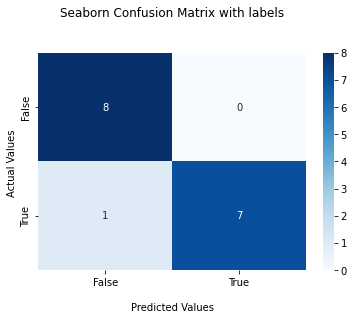

In [ ]:
import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score
test_accuracy9 = accuracy_score(all_labels, all_preds)
print('Accuracy: %.3f' % test_accuracy9)
precision9 = precision_score(all_labels, all_preds, average='macro')
print('Precision: %.3f' % precision9)
recall9 = recall_score(all_labels, all_preds, average='macro')
print('Recall: %.3f' % recall9)
score9 = f1_score(all_labels, all_preds, average='macro')
print('F-Measure: %.3f' % score9)

Accuracy: 0.938
Precision: 0.944
Recall: 0.938
F-Measure: 0.937


# For Looping

In [ ]:
if precision9 >= precision and recall9 >= recall and score9 >= score :
  torch.save(model2.state_dict(), "/content/drive/MyDrive/Colab Notebooks/Dataset/news_model1.pth")
  precision = precision9
  recall = recall9
  score = score9
  model.fc1.weight.data =model2.fc1.weight.data.clone()
  model.fc1.bias.data =model2.fc1.bias.data.clone()
  model.fc2.weight.data =model2.fc2.weight.data.clone()
  model.fc2.bias.data =model2.fc2.bias.data.clone()

# 10th Model


In [ ]:
class NewsDatasets(Dataset):
    def __init__(self, data, max_length=100):
        self.data = data
        
        self.config = {
            "max_length": max_length,
            "padding": "max_length",
            "return_tensors": "pt",
            "truncation": True,
            "add_special_tokens": True
        }

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        value = self.data.iloc[idx]
        return value['head']+"[SEP]"+value['con'] , value['label']

In [ ]:
auth = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dataset/For Sentiment /Division /40%/auth_set_10.csv",encoding='UTF-8')
fake = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dataset/For Sentiment /Division /40%/fake_set_10.csv",encoding='UTF-8')


print(len(auth))
print(len(fake))


1497
40


In [ ]:

#df = auth[:fake.shape[0]* 7]
df = auth.append(fake)
df = df.sample(frac=1).reset_index(drop=True)
len(df)

1537

In [ ]:
from bnlp import BasicTokenizer
from bnlp.corpus import stopwords, punctuations, letters, digits

btokenizer = BasicTokenizer()

def clean_text(text):
    tokens = btokenizer.tokenize(text)
    filtered = []
    for i in tokens:
        if i in stopwords:
            continue
    
        if i in punctuations + '‘' + '’':
            continue
    
        filtered.append(i)
    
    return " ".join(filtered)

print("********** Before ***************")
text = df.iloc[1]['content']
print(text)
print("\n********** After ***************")
print(clean_text(text))

********** Before ***************
ফেনী সদরের লালপোল এলাকা থেকে ১০ হাজার পিস ইয়াবা ট্যাবলেটসহ চার মাদক ব্যবসায়ীকে আটক করা হয়েছে। সোমবার (৮ অক্টোবর) রাতে লালপোল কাবাব ঘরের সামনে প্রাইভেটকার তল্লাশি করে তাদের আটক করে মাদকদ্রব্য নিয়ন্ত্রণ অধিদফতর। জেলা মাদকদ্রব্য নিয়ন্ত্রণ অধিদফতরের সহকারী পরিচালক আবু আবদুল্লাহ জাহিদ এ তথ্য নিশ্চিত করেন। আটক চার জন হলো– ফরিদপুর জেলার মোশারফ মিয়ার ছেলে মো. সোহেল (২৩) এবং রাজবাড়ী জেলার মো. বদর উদ্দিনের ছেলে রাসেল শেখ (২০), আক্কাস আলী মোল্লার ছেলে রুবেল মোল্লা (২৬) ও আবদুল কাদের শেখের ছেলে মো. ফরিদ (২৫)। আবু আব্দুল্লাহ জাহিদ বলেন, ‘ সোমবার রাতে ফেনী মাদকদ্রব্য নিয়ন্ত্রণ অধিদফতরের একটি টিম লালপোলে অবস্থান নেয়। রাত সাড়ে ১০টার দিকে চট্টগ্রাম থেকে ঢাকাগামী একটি এক্স করোলা প্রাইভেটকার (ঢাকা মেট্টো- ২৫-৮৭৫৬) থামিয়ে তল্লাশি করে তারা। এসময় ওই গাড়িতে ১০ হাজার পিস ইয়াবা ট্যাবলেট পাওয়া যায়। আটক করা হয় গাড়িতে থাকা চার জনকে।’ ফেনী মডেল থানার ভারপ্রাপ্ত কর্মকর্তা (ওসি) আবুল কালাম আজাদ জানান, এ ঘটনায় থানায় মাদক আইনে মামলা দায়ের করা হয়েছে।

********** After ***************
ফ

In [ ]:
undersample = RandomUnderSampler(sampling_strategy='majority')

In [ ]:
df['head'] = df.headline.apply(clean_text)
df['con'] = df.content.apply(clean_text)

In [ ]:
x= df.drop('label', axis=1)
y= df.label

In [ ]:
X_train_resampled, y_train_resampled = undersample.fit_resample(x, y)

In [ ]:
df = X_train_resampled.join(y_train_resampled)

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=121, stratify=df['label'])

In [ ]:
len(train_df), len(test_df)

(64, 16)

In [ ]:
training_data = NewsDatasets(train_df)
train_dataloader = DataLoader(training_data, batch_size=1, shuffle=True)

In [ ]:
test_data = NewsDatasets(test_df)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=True)

In [ ]:
class NewsBert2(nn.Module):

    def __init__(self, bert):
        super(NewsBert2, self).__init__()

        self.bert = bert

        # dropout layer
        self.dropout = nn.Dropout(0.2)

        # relu activation function
        self.relu = nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768, 128)

        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(128, 2)  

    # define the forward pass
    def forward(self, input_ids, token_type_ids, attention_mask):
        # pass the inputs to the model
        out = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

        x = self.fc1(out[1])
        x = self.relu(x)
        # output layer
        x = self.fc2(self.dropout(x))
        
        return x

In [ ]:
bert_model_name = "sagorsarker/bangla-bert-base"
bert = BertModel.from_pretrained(bert_model_name)
tokenizer = BertTokenizer.from_pretrained(bert_model_name)

Some weights of the model checkpoint at sagorsarker/bangla-bert-base were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2 = NewsBert(bert)
model2.to(device);

In [ ]:
from torch.optim.lr_scheduler import StepLR

optimizer = AdamW(model2.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

In [ ]:
model2.fc1.weight.data =model.fc1.weight.data.clone()
model2.fc1.bias.data =model.fc1.bias.data.clone()
model2.fc2.weight.data =model.fc2.weight.data.clone()
model2.fc2.bias.data =model.fc2.bias.data.clone()

In [ ]:
print(model2.fc1.weight.data)

tensor([[ 0.0214, -0.0063,  0.0298,  ..., -0.0273, -0.0140,  0.0203],
        [ 0.0182, -0.0057,  0.0161,  ...,  0.0106, -0.0311,  0.0291],
        [-0.0292,  0.0250,  0.0125,  ...,  0.0283,  0.0277,  0.0023],
        ...,
        [-0.0008, -0.0249,  0.0310,  ...,  0.0050, -0.0116, -0.0298],
        [-0.0125,  0.0083, -0.0215,  ...,  0.0036, -0.0193,  0.0224],
        [-0.0232,  0.0303, -0.0267,  ...,  0.0061,  0.0165, -0.0014]],
       device='cuda:0')


In [ ]:
def train(model, dataloader, optimizer, criterion, config):
    model2.train()  # prep model for training
    train_loss = 0
    for batch in tqdm(dataloader):
        text, labels = batch

        model2.zero_grad()

        inputs = tokenizer.batch_encode_plus(
            text, **config
        )
        input_ids = inputs['input_ids'].to(device)
        token_type_ids = inputs['token_type_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        # move things to model
        logs = model2(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)

        loss = criterion(logs, labels)
        train_loss += loss.item() * input_ids.size(0)
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        nn.utils.clip_grad_norm_(model2.parameters(), 1.0)
        optimizer.step()

    return train_loss

In [ ]:
def evaluate(model, dataloader, criterion, config):
    total = 0
    correct = 0
    valid_loss = 0.0

    model2.eval()  # prep model for evaluation
    for batch in dataloader:
        text, labels = batch
        inputs = tokenizer.batch_encode_plus(
            text, **config
        )
        input_ids = inputs['input_ids'].to(device)
        token_type_ids = inputs['token_type_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        # move things to model
        output = model2(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)

        loss_p = criterion(output, labels)
        # update running validation loss
        valid_loss += loss_p.item() * input_ids.size(0)
        # calculate accuracy
        proba = torch.exp(output)
        top_p, top_class = proba.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        # accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return total, correct, valid_loss

In [ ]:
epochs = 5
tokenizer_config = {
    "max_length": 100,
    "padding": "max_length",
    "return_tensors": "pt",
    "truncation": True,
    "add_special_tokens": True
}

In [ ]:
train_loss_data, valid_loss_data = [], []
valid_loss_min = np.Inf
since = time.time()
best_loss = np.inf

for epoch in range(epochs):
    print("Epoch: {}/{}".format(epoch + 1, epochs))
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    total = 0
    correct = 0
    e_since = time.time()

    # Train Model
    train_loss += train(model2, train_dataloader, optimizer, criterion, tokenizer_config)
    # Now Evaluate
    out = evaluate(model2, test_dataloader, criterion, tokenizer_config)
    total += out[0]
    correct += out[1]
    valid_loss += out[2]
    
    scheduler.step()

    # print training/validation statistics
    # calculate average loss over an epoch
    train_loss = train_loss / len(train_dataloader.dataset)
    valid_loss = valid_loss / len(test_dataloader.dataset)

    # calculate train loss and running loss
    train_loss_data.append(train_loss * 100)
    valid_loss_data.append(valid_loss * 100)
    
    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(model2.state_dict(), "/content/drive/MyDrive/Colab Notebooks/Dataset/news_model2.pth")

    print("\tTrain loss:{:.6f}..".format(train_loss),
          "\tValid Loss:{:.6f}..".format(valid_loss),
          "\tAccuracy: {:.4f}".format(correct / total * 100))

time_elapsed = time.time() - since
print('Training completed in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

Epoch: 1/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.789761.. 	Valid Loss:0.679539.. 	Accuracy: 50.0000
Epoch: 2/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.449245.. 	Valid Loss:0.860089.. 	Accuracy: 62.5000
Epoch: 3/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.206145.. 	Valid Loss:0.819650.. 	Accuracy: 68.7500
Epoch: 4/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.194195.. 	Valid Loss:0.917622.. 	Accuracy: 68.7500
Epoch: 5/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.173018.. 	Valid Loss:0.925296.. 	Accuracy: 68.7500
Training completed in 0m 40s


In [ ]:
training_acc10 = correct / total * 100
training_acc10

68.75

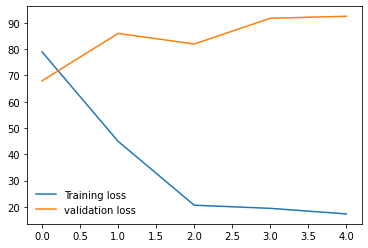

In [ ]:
from matplotlib import pyplot as plt

plt.plot(train_loss_data, label="Training loss")
plt.plot(valid_loss_data, label="validation loss")
plt.legend(frameon=False)

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
from google.colab import output
output.disable_custom_widget_manager()

In [ ]:
model2.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/Dataset/news_model2.pth", map_location = device))

<All keys matched successfully>

In [ ]:
all_preds = []
all_labels = []

for batch in test_dataloader:
    text, labels = batch
    inputs = tokenizer.batch_encode_plus(
        text, **tokenizer_config
    )
    input_ids = inputs['input_ids'].to(device)
    token_type_ids = inputs['token_type_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    labels = labels.to(device)

    # move things to model
    output = model2(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)
    preds = output.detach().cpu().numpy()
    preds = np.argmax(preds, axis = 1)
    all_preds.extend(preds)
    all_labels.extend(labels.cpu().numpy())

In [ ]:
from sklearn.metrics import classification_report

# preds = np.argmax(preds, axis = 1)
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         8
           1       0.50      1.00      0.67         8

    accuracy                           0.50        16
   macro avg       0.25      0.50      0.33        16
weighted avg       0.25      0.50      0.33        16



In [ ]:
print(model2.fc1.weight.data)

tensor([[ 0.0215, -0.0060,  0.0298,  ..., -0.0274, -0.0137,  0.0202],
        [ 0.0182, -0.0058,  0.0161,  ...,  0.0107, -0.0312,  0.0291],
        [-0.0292,  0.0249,  0.0126,  ...,  0.0283,  0.0277,  0.0024],
        ...,
        [-0.0008, -0.0250,  0.0310,  ...,  0.0049, -0.0116, -0.0298],
        [-0.0124,  0.0082, -0.0215,  ...,  0.0037, -0.0193,  0.0225],
        [-0.0231,  0.0302, -0.0267,  ...,  0.0061,  0.0165, -0.0014]],
       device='cuda:0')


In [ ]:
cf_matrix = confusion_matrix(all_labels, all_preds)  

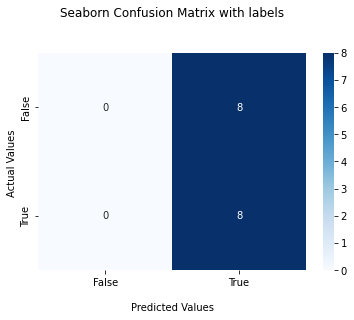

In [ ]:
import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score
test_accuracy10 = accuracy_score(all_labels, all_preds)
print('Accuracy: %.3f' % test_accuracy10)
precision10 = precision_score(all_labels, all_preds, average='macro')
print('Precision: %.3f' % precision10)
recall10 = recall_score(all_labels, all_preds, average='macro')
print('Recall: %.3f' % recall10)
score10 = f1_score(all_labels, all_preds, average='macro')
print('F-Measure: %.3f' % score10)

Accuracy: 0.500
Precision: 0.250
Recall: 0.500
F-Measure: 0.333


# For Looping

In [ ]:
if precision10 >= precision and recall10 >= recall and score10 >= score :
  torch.save(model2.state_dict(), "/content/drive/MyDrive/Colab Notebooks/Dataset/news_model1.pth")
  precision = precision10
  recall = recall10
  score = score10
  model.fc1.weight.data =model2.fc1.weight.data.clone()
  model.fc1.bias.data =model2.fc1.bias.data.clone()
  model.fc2.weight.data =model2.fc2.weight.data.clone()
  model.fc2.bias.data =model2.fc2.bias.data.clone()

# 11th Model


In [ ]:
class NewsDatasets(Dataset):
    def __init__(self, data, max_length=100):
        self.data = data
        
        self.config = {
            "max_length": max_length,
            "padding": "max_length",
            "return_tensors": "pt",
            "truncation": True,
            "add_special_tokens": True
        }

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        value = self.data.iloc[idx]
        return value['head']+"[SEP]"+value['con'] , value['label']

In [ ]:
auth = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dataset/For Sentiment /Division /40%/auth_set_11.csv",encoding='UTF-8')
fake = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dataset/For Sentiment /Division /40%/fake_set_11.csv",encoding='UTF-8')


print(len(auth))
print(len(fake))


1497
40


In [ ]:

#df = auth[:fake.shape[0]* 7]
df = auth.append(fake)
df = df.sample(frac=1).reset_index(drop=True)
len(df)

1537

In [ ]:
from bnlp import BasicTokenizer
from bnlp.corpus import stopwords, punctuations, letters, digits

btokenizer = BasicTokenizer()

def clean_text(text):
    tokens = btokenizer.tokenize(text)
    filtered = []
    for i in tokens:
        if i in stopwords:
            continue
    
        if i in punctuations + '‘' + '’':
            continue
    
        filtered.append(i)
    
    return " ".join(filtered)

print("********** Before ***************")
text = df.iloc[1]['content']
print(text)
print("\n********** After ***************")
print(clean_text(text))

********** Before ***************
দুবাইয়ে সিরিজের প্রথম টেস্টের প্রথম ইনিংসে পাকিস্তানি বোলারদের বোলিং আগ্রাসনে বিধ্বস্ত হয়েছে অস্ট্রেলিয়ার ব্যাটিং লাইনআপ। উদ্বোধনী জুটিতে ১৪২ রান তোলা অস্ট্রেলিয়া পরবর্তী ৬০ রানের মধ্যে হারিয়েছে সবগুলো উইকেট। ফলে দলটি গুটিয়ে গেছে ২০২ রানে। পাকিস্তানের চেয়ে প্রথম ইনিংসে তারা পিছিয়ে আছে ২৮০ রানে। প্রথম ইনিংস শেষে ২৮০ রানে পিছিয়ে থাকলেও অস্ট্রেলিয়াকে ফলোঅন না করিয়ে নিজেদের দ্বিতীয় ইনিংসে ব্যাট করতে নেমেছে পাকিস্তান। মঙ্গলবার (৯ অক্টোবর), লাঞ্চ ব্রেকের পরই জ্বলে ওঠেন পাকিস্তানের দুই বোলার অফ স্পিনার বিলাল আসিফ ও পেসার মোহাম্মাদ আব্বাস। দুজনে ভাগাভাগি করে নিয়েছেন অস্ট্রেলিয়ার ১০টি উইকেট। অভিষিক্ত ডান হাতি অফস্পিনার বিলাল আসিফ অভিষেকটাকে স্মরণীয় করে রাখার মতো বোলিং করেছেন। ২১ দশমিক ৩ ওভার বোলিং করে মাত্র ৩৬ রান খরচ করে তুলে নিয়েছেন ৬টি উইকেট। অন্যদিকে আব্বাস নিয়েছেন ২৯ রানে ৪ উইকেট। এর আগে নিজেদের প্রথম ইনিংসে ৪৮২ রানে অলআউট হয় পাকিস্তান। জবাবে ২০২ রানে গুটিয়ে যায় অস্ট্রেলিয়ার প্রথম ইনিংস। সর্বোচ্চ ৮৫ রান করেছেন উসমান খাজা। ২৮০ রানের লিড নিয়ে দ্বিতীয় ইনিংসে 

In [ ]:
undersample = RandomUnderSampler(sampling_strategy='majority')

In [ ]:
df['head'] = df.headline.apply(clean_text)
df['con'] = df.content.apply(clean_text)

In [ ]:
x= df.drop('label', axis=1)
y= df.label

In [ ]:
X_train_resampled, y_train_resampled = undersample.fit_resample(x, y)

In [ ]:
df = X_train_resampled.join(y_train_resampled)

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=121, stratify=df['label'])

In [ ]:
len(train_df), len(test_df)

(64, 16)

In [ ]:
training_data = NewsDatasets(train_df)
train_dataloader = DataLoader(training_data, batch_size=1, shuffle=True)

In [ ]:
test_data = NewsDatasets(test_df)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=True)

In [ ]:
class NewsBert2(nn.Module):

    def __init__(self, bert):
        super(NewsBert2, self).__init__()

        self.bert = bert

        # dropout layer
        self.dropout = nn.Dropout(0.2)

        # relu activation function
        self.relu = nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768, 128)

        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(128, 2)  

    # define the forward pass
    def forward(self, input_ids, token_type_ids, attention_mask):
        # pass the inputs to the model
        out = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

        x = self.fc1(out[1])
        x = self.relu(x)
        # output layer
        x = self.fc2(self.dropout(x))
        
        return x

In [ ]:
bert_model_name = "sagorsarker/bangla-bert-base"
bert = BertModel.from_pretrained(bert_model_name)
tokenizer = BertTokenizer.from_pretrained(bert_model_name)

Some weights of the model checkpoint at sagorsarker/bangla-bert-base were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2 = NewsBert(bert)
model2.to(device);

In [ ]:
from torch.optim.lr_scheduler import StepLR

optimizer = AdamW(model2.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

In [ ]:
model2.fc1.weight.data =model.fc1.weight.data.clone()
model2.fc1.bias.data =model.fc1.bias.data.clone()
model2.fc2.weight.data =model.fc2.weight.data.clone()
model2.fc2.bias.data =model.fc2.bias.data.clone()

In [ ]:
print(model2.fc1.weight.data)

tensor([[ 0.0214, -0.0063,  0.0298,  ..., -0.0273, -0.0140,  0.0203],
        [ 0.0182, -0.0057,  0.0161,  ...,  0.0106, -0.0311,  0.0291],
        [-0.0292,  0.0250,  0.0125,  ...,  0.0283,  0.0277,  0.0023],
        ...,
        [-0.0008, -0.0249,  0.0310,  ...,  0.0050, -0.0116, -0.0298],
        [-0.0125,  0.0083, -0.0215,  ...,  0.0036, -0.0193,  0.0224],
        [-0.0232,  0.0303, -0.0267,  ...,  0.0061,  0.0165, -0.0014]],
       device='cuda:0')


In [ ]:
def train(model, dataloader, optimizer, criterion, config):
    model2.train()  # prep model for training
    train_loss = 0
    for batch in tqdm(dataloader):
        text, labels = batch

        model2.zero_grad()

        inputs = tokenizer.batch_encode_plus(
            text, **config
        )
        input_ids = inputs['input_ids'].to(device)
        token_type_ids = inputs['token_type_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        # move things to model
        logs = model2(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)

        loss = criterion(logs, labels)
        train_loss += loss.item() * input_ids.size(0)
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        nn.utils.clip_grad_norm_(model2.parameters(), 1.0)
        optimizer.step()

    return train_loss

In [ ]:
def evaluate(model, dataloader, criterion, config):
    total = 0
    correct = 0
    valid_loss = 0.0

    model2.eval()  # prep model for evaluation
    for batch in dataloader:
        text, labels = batch
        inputs = tokenizer.batch_encode_plus(
            text, **config
        )
        input_ids = inputs['input_ids'].to(device)
        token_type_ids = inputs['token_type_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        # move things to model
        output = model2(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)

        loss_p = criterion(output, labels)
        # update running validation loss
        valid_loss += loss_p.item() * input_ids.size(0)
        # calculate accuracy
        proba = torch.exp(output)
        top_p, top_class = proba.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        # accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return total, correct, valid_loss

In [ ]:
epochs = 5
tokenizer_config = {
    "max_length": 100,
    "padding": "max_length",
    "return_tensors": "pt",
    "truncation": True,
    "add_special_tokens": True
}

In [ ]:
train_loss_data, valid_loss_data = [], []
valid_loss_min = np.Inf
since = time.time()
best_loss = np.inf

for epoch in range(epochs):
    print("Epoch: {}/{}".format(epoch + 1, epochs))
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    total = 0
    correct = 0
    e_since = time.time()

    # Train Model
    train_loss += train(model2, train_dataloader, optimizer, criterion, tokenizer_config)
    # Now Evaluate
    out = evaluate(model2, test_dataloader, criterion, tokenizer_config)
    total += out[0]
    correct += out[1]
    valid_loss += out[2]
    
    scheduler.step()

    # print training/validation statistics
    # calculate average loss over an epoch
    train_loss = train_loss / len(train_dataloader.dataset)
    valid_loss = valid_loss / len(test_dataloader.dataset)

    # calculate train loss and running loss
    train_loss_data.append(train_loss * 100)
    valid_loss_data.append(valid_loss * 100)
    
    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(model2.state_dict(), "/content/drive/MyDrive/Colab Notebooks/Dataset/news_model2.pth")

    print("\tTrain loss:{:.6f}..".format(train_loss),
          "\tValid Loss:{:.6f}..".format(valid_loss),
          "\tAccuracy: {:.4f}".format(correct / total * 100))

time_elapsed = time.time() - since
print('Training completed in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

Epoch: 1/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.826738.. 	Valid Loss:0.590219.. 	Accuracy: 62.5000
Epoch: 2/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.303774.. 	Valid Loss:0.494420.. 	Accuracy: 81.2500
Epoch: 3/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.156318.. 	Valid Loss:0.496796.. 	Accuracy: 81.2500
Epoch: 4/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.126115.. 	Valid Loss:0.530083.. 	Accuracy: 75.0000
Epoch: 5/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.101032.. 	Valid Loss:0.532954.. 	Accuracy: 75.0000
Training completed in 0m 47s


In [ ]:
training_acc11 = correct / total * 100
training_acc11

75.0

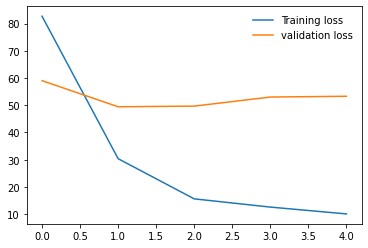

In [ ]:
from matplotlib import pyplot as plt

plt.plot(train_loss_data, label="Training loss")
plt.plot(valid_loss_data, label="validation loss")
plt.legend(frameon=False)

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
from google.colab import output
output.disable_custom_widget_manager()

In [ ]:
model2.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/Dataset/news_model2.pth", map_location = device))

<All keys matched successfully>

In [ ]:
all_preds = []
all_labels = []

for batch in test_dataloader:
    text, labels = batch
    inputs = tokenizer.batch_encode_plus(
        text, **tokenizer_config
    )
    input_ids = inputs['input_ids'].to(device)
    token_type_ids = inputs['token_type_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    labels = labels.to(device)

    # move things to model
    output = model2(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)
    preds = output.detach().cpu().numpy()
    preds = np.argmax(preds, axis = 1)
    all_preds.extend(preds)
    all_labels.extend(labels.cpu().numpy())

In [ ]:
from sklearn.metrics import classification_report

# preds = np.argmax(preds, axis = 1)
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.78      0.88      0.82         8
           1       0.86      0.75      0.80         8

    accuracy                           0.81        16
   macro avg       0.82      0.81      0.81        16
weighted avg       0.82      0.81      0.81        16



In [ ]:
print(model2.fc1.weight.data)

tensor([[ 0.0214, -0.0058,  0.0295,  ..., -0.0272, -0.0138,  0.0204],
        [ 0.0180, -0.0059,  0.0161,  ...,  0.0108, -0.0313,  0.0292],
        [-0.0298,  0.0244,  0.0130,  ...,  0.0283,  0.0272,  0.0021],
        ...,
        [-0.0011, -0.0254,  0.0311,  ...,  0.0050, -0.0120, -0.0299],
        [-0.0121,  0.0087, -0.0219,  ...,  0.0036, -0.0188,  0.0229],
        [-0.0235,  0.0299, -0.0263,  ...,  0.0061,  0.0161, -0.0017]],
       device='cuda:0')


In [ ]:
cf_matrix = confusion_matrix(all_labels, all_preds)  

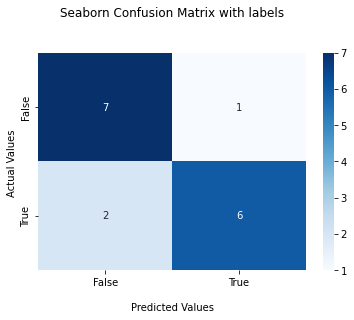

In [ ]:
import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score
test_accuracy11 = accuracy_score(all_labels, all_preds)
print('Accuracy: %.3f' % test_accuracy11)
precision11 = precision_score(all_labels, all_preds, average='macro')
print('Precision: %.3f' % precision11)
recall11 = recall_score(all_labels, all_preds, average='macro')
print('Recall: %.3f' % recall11)
score11 = f1_score(all_labels, all_preds, average='macro')
print('F-Measure: %.3f' % score11)

Accuracy: 0.812
Precision: 0.817
Recall: 0.812
F-Measure: 0.812


# For Looping

In [ ]:
if precision11 >= precision and recall11 >= recall and score11 >= score :
  torch.save(model2.state_dict(), "/content/drive/MyDrive/Colab Notebooks/Dataset/news_model1.pth")
  precision = precision11
  recall = recall11
  score = score11
  model.fc1.weight.data =model2.fc1.weight.data.clone()
  model.fc1.bias.data =model2.fc1.bias.data.clone()
  model.fc2.weight.data =model2.fc2.weight.data.clone()
  model.fc2.bias.data =model2.fc2.bias.data.clone()

# 12th Model


In [ ]:
class NewsDatasets(Dataset):
    def __init__(self, data, max_length=100):
        self.data = data
        
        self.config = {
            "max_length": max_length,
            "padding": "max_length",
            "return_tensors": "pt",
            "truncation": True,
            "add_special_tokens": True
        }

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        value = self.data.iloc[idx]
        return value['head']+"[SEP]"+value['con'] , value['label']

In [ ]:
auth = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dataset/For Sentiment /Division /40%/auth_set_12.csv",encoding='UTF-8')
fake = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dataset/For Sentiment /Division /40%/fake_set_12.csv",encoding='UTF-8')


print(len(auth))
print(len(fake))


1497
40


In [ ]:

#df = auth[:fake.shape[0]* 7]
df = auth.append(fake)
df = df.sample(frac=1).reset_index(drop=True)
len(df)

1537

In [ ]:
from bnlp import BasicTokenizer
from bnlp.corpus import stopwords, punctuations, letters, digits

btokenizer = BasicTokenizer()

def clean_text(text):
    tokens = btokenizer.tokenize(text)
    filtered = []
    for i in tokens:
        if i in stopwords:
            continue
    
        if i in punctuations + '‘' + '’':
            continue
    
        filtered.append(i)
    
    return " ".join(filtered)

print("********** Before ***************")
text = df.iloc[1]['content']
print(text)
print("\n********** After ***************")
print(clean_text(text))

********** Before ***************
ইডেন যখন সেজে উঠছে ৪ নবেম্বর ভারত ও ওয়েস্ট ইন্ডিজের মধ্যে প্রথম টি-টোয়েন্টি ম্যাচ আয়োজনের জন্য, তখন মুম্বাইয়ের ওয়াংখেড়ে স্টেডিয়ামে এই সিরিজের চতুর্থ ওয়ান ডে ম্যাচ হবে কি না তা নিয়েই অনিশ্চয়তা দেখা দিয়েছে। ইতিমধ্যেই উইকেট ও মাঠের মেরামতির কাজ শুরু হয়ে গিয়েছে ইডেনে। টিকিটও ছাপা প্রায় সম্পূর্ণ। পুজোর পরে তা বিতরণও শুরু হবে। সেই ম্যাচের জন্য চলছে গ্যালারি মেরামতির কাজও। কাজ চলছে এল ব্লকের গ্যালারিতে। শুরু হয়ে গিয়েছে ইডেনের স্কোরবোর্ড ঢালাই করার কাজও। দুর্গোৎসবের রেশ কাটতে না কাটতেই কালীপুজোর আগে ইডেনে আবার হয়তো দেখা যাবে কলকাতা নাইট রাইডার্সের তারকা অলরাউন্ডার আন্দ্রে রাসেলকে। খেলতে দেখা যেতে পারে ড্যারেন ব্র্যাভো, কায়রন পোলার্ড, কার্লোস ব্র্যাথওয়েটদেরও। ইডেনে যখন এই সাজগোজের পালা চলছে, তখন মুম্বইয়ের ওয়াংখেড়ে স্টেডিয়ামে রোহিত শর্মা-জেসন হোল্ডার-রা আদৌ নামতে পারবেন কি না তা নিয়েই তৈরি হয়েছে বড়সড় জট। শোনা যাচ্ছে, বোর্ড ও মুম্বাই ক্রিকেট সংস্থার (এমসিএ) কর্তারা আলোচনা করেও এই সমস্যার কোনও সমাধান করতে পারেননি। এক এমসিএ কর্তা জানিয়েছেন, তাঁদের সংস্থার কমিটি

In [ ]:
undersample = RandomUnderSampler(sampling_strategy='majority')

In [ ]:
df['head'] = df.headline.apply(clean_text)
df['con'] = df.content.apply(clean_text)

In [ ]:
x= df.drop('label', axis=1)
y= df.label

In [ ]:
X_train_resampled, y_train_resampled = undersample.fit_resample(x, y)

In [ ]:
df = X_train_resampled.join(y_train_resampled)

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=121, stratify=df['label'])

In [ ]:
len(train_df), len(test_df)

(64, 16)

In [ ]:
training_data = NewsDatasets(train_df)
train_dataloader = DataLoader(training_data, batch_size=1, shuffle=True)

In [ ]:
test_data = NewsDatasets(test_df)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=True)

In [ ]:
class NewsBert2(nn.Module):

    def __init__(self, bert):
        super(NewsBert2, self).__init__()

        self.bert = bert

        # dropout layer
        self.dropout = nn.Dropout(0.2)

        # relu activation function
        self.relu = nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768, 128)

        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(128, 2)  

    # define the forward pass
    def forward(self, input_ids, token_type_ids, attention_mask):
        # pass the inputs to the model
        out = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

        x = self.fc1(out[1])
        x = self.relu(x)
        # output layer
        x = self.fc2(self.dropout(x))
        
        return x

In [ ]:
bert_model_name = "sagorsarker/bangla-bert-base"
bert = BertModel.from_pretrained(bert_model_name)
tokenizer = BertTokenizer.from_pretrained(bert_model_name)

Some weights of the model checkpoint at sagorsarker/bangla-bert-base were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2 = NewsBert(bert)
model2.to(device);

In [ ]:
from torch.optim.lr_scheduler import StepLR

optimizer = AdamW(model2.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

In [ ]:
model2.fc1.weight.data =model.fc1.weight.data.clone()
model2.fc1.bias.data =model.fc1.bias.data.clone()
model2.fc2.weight.data =model.fc2.weight.data.clone()
model2.fc2.bias.data =model.fc2.bias.data.clone()

In [ ]:
print(model2.fc1.weight.data)

tensor([[ 0.0214, -0.0063,  0.0298,  ..., -0.0273, -0.0140,  0.0203],
        [ 0.0182, -0.0057,  0.0161,  ...,  0.0106, -0.0311,  0.0291],
        [-0.0292,  0.0250,  0.0125,  ...,  0.0283,  0.0277,  0.0023],
        ...,
        [-0.0008, -0.0249,  0.0310,  ...,  0.0050, -0.0116, -0.0298],
        [-0.0125,  0.0083, -0.0215,  ...,  0.0036, -0.0193,  0.0224],
        [-0.0232,  0.0303, -0.0267,  ...,  0.0061,  0.0165, -0.0014]],
       device='cuda:0')


In [ ]:
def train(model, dataloader, optimizer, criterion, config):
    model2.train()  # prep model for training
    train_loss = 0
    for batch in tqdm(dataloader):
        text, labels = batch

        model2.zero_grad()

        inputs = tokenizer.batch_encode_plus(
            text, **config
        )
        input_ids = inputs['input_ids'].to(device)
        token_type_ids = inputs['token_type_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        # move things to model
        logs = model2(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)

        loss = criterion(logs, labels)
        train_loss += loss.item() * input_ids.size(0)
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        nn.utils.clip_grad_norm_(model2.parameters(), 1.0)
        optimizer.step()

    return train_loss

In [ ]:
def evaluate(model, dataloader, criterion, config):
    total = 0
    correct = 0
    valid_loss = 0.0

    model2.eval()  # prep model for evaluation
    for batch in dataloader:
        text, labels = batch
        inputs = tokenizer.batch_encode_plus(
            text, **config
        )
        input_ids = inputs['input_ids'].to(device)
        token_type_ids = inputs['token_type_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        # move things to model
        output = model2(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)

        loss_p = criterion(output, labels)
        # update running validation loss
        valid_loss += loss_p.item() * input_ids.size(0)
        # calculate accuracy
        proba = torch.exp(output)
        top_p, top_class = proba.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        # accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return total, correct, valid_loss

In [ ]:
epochs = 5
tokenizer_config = {
    "max_length": 100,
    "padding": "max_length",
    "return_tensors": "pt",
    "truncation": True,
    "add_special_tokens": True
}

In [ ]:
train_loss_data, valid_loss_data = [], []
valid_loss_min = np.Inf
since = time.time()
best_loss = np.inf

for epoch in range(epochs):
    print("Epoch: {}/{}".format(epoch + 1, epochs))
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    total = 0
    correct = 0
    e_since = time.time()

    # Train Model
    train_loss += train(model2, train_dataloader, optimizer, criterion, tokenizer_config)
    # Now Evaluate
    out = evaluate(model2, test_dataloader, criterion, tokenizer_config)
    total += out[0]
    correct += out[1]
    valid_loss += out[2]
    
    scheduler.step()

    # print training/validation statistics
    # calculate average loss over an epoch
    train_loss = train_loss / len(train_dataloader.dataset)
    valid_loss = valid_loss / len(test_dataloader.dataset)

    # calculate train loss and running loss
    train_loss_data.append(train_loss * 100)
    valid_loss_data.append(valid_loss * 100)
    
    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(model2.state_dict(), "/content/drive/MyDrive/Colab Notebooks/Dataset/news_model2.pth")

    print("\tTrain loss:{:.6f}..".format(train_loss),
          "\tValid Loss:{:.6f}..".format(valid_loss),
          "\tAccuracy: {:.4f}".format(correct / total * 100))

time_elapsed = time.time() - since
print('Training completed in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

Epoch: 1/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.700865.. 	Valid Loss:0.571306.. 	Accuracy: 75.0000
Epoch: 2/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.243811.. 	Valid Loss:0.467184.. 	Accuracy: 75.0000
Epoch: 3/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.060092.. 	Valid Loss:0.471968.. 	Accuracy: 75.0000
Epoch: 4/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.052207.. 	Valid Loss:0.474789.. 	Accuracy: 87.5000
Epoch: 5/5


  0%|          | 0/64 [00:00<?, ?it/s]

	Train loss:0.051841.. 	Valid Loss:0.472324.. 	Accuracy: 87.5000
Training completed in 0m 44s


In [ ]:
training_acc12 = correct / total * 100
training_acc12

87.5

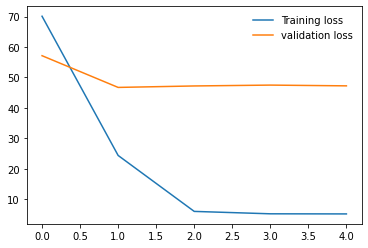

In [ ]:
from matplotlib import pyplot as plt

plt.plot(train_loss_data, label="Training loss")
plt.plot(valid_loss_data, label="validation loss")
plt.legend(frameon=False)

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
from google.colab import output
output.disable_custom_widget_manager()

In [ ]:
model2.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/Dataset/news_model2.pth", map_location = device))

<All keys matched successfully>

In [ ]:
all_preds = []
all_labels = []

for batch in test_dataloader:
    text, labels = batch
    inputs = tokenizer.batch_encode_plus(
        text, **tokenizer_config
    )
    input_ids = inputs['input_ids'].to(device)
    token_type_ids = inputs['token_type_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    labels = labels.to(device)

    # move things to model
    output = model2(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)
    preds = output.detach().cpu().numpy()
    preds = np.argmax(preds, axis = 1)
    all_preds.extend(preds)
    all_labels.extend(labels.cpu().numpy())

In [ ]:
from sklearn.metrics import classification_report

# preds = np.argmax(preds, axis = 1)
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.75      0.75      0.75         8
           1       0.75      0.75      0.75         8

    accuracy                           0.75        16
   macro avg       0.75      0.75      0.75        16
weighted avg       0.75      0.75      0.75        16



In [ ]:
print(model2.fc1.weight.data)

tensor([[ 0.0214, -0.0059,  0.0297,  ..., -0.0273, -0.0138,  0.0205],
        [ 0.0183, -0.0060,  0.0163,  ...,  0.0107, -0.0314,  0.0290],
        [-0.0295,  0.0246,  0.0130,  ...,  0.0282,  0.0274,  0.0020],
        ...,
        [-0.0012, -0.0253,  0.0312,  ...,  0.0049, -0.0119, -0.0300],
        [-0.0121,  0.0087, -0.0219,  ...,  0.0038, -0.0188,  0.0227],
        [-0.0237,  0.0298, -0.0263,  ...,  0.0061,  0.0160, -0.0017]],
       device='cuda:0')


In [ ]:
cf_matrix = confusion_matrix(all_labels, all_preds)  

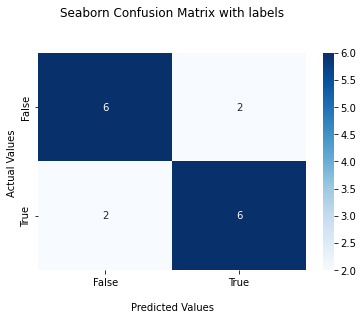

In [ ]:
import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score
test_accuracy12 = accuracy_score(all_labels, all_preds)
print('Accuracy: %.3f' % test_accuracy12)
precision12 = precision_score(all_labels, all_preds, average='macro')
print('Precision: %.3f' % precision12)
recall12 = recall_score(all_labels, all_preds, average='macro')
print('Recall: %.3f' % recall12)
score12 = f1_score(all_labels, all_preds, average='macro')
print('F-Measure: %.3f' % score12)

Accuracy: 0.750
Precision: 0.750
Recall: 0.750
F-Measure: 0.750


# For Looping

In [ ]:
if precision12 >= precision and recall12 >= recall and score12 >= score :
  torch.save(model2.state_dict(), "/content/drive/MyDrive/Colab Notebooks/Dataset/news_model1.pth")
  precision = precision12
  recall = recall12
  score = score12
  model.fc1.weight.data =model2.fc1.weight.data.clone()
  model.fc1.bias.data =model2.fc1.bias.data.clone()
  model.fc2.weight.data =model2.fc2.weight.data.clone()
  model.fc2.bias.data =model2.fc2.bias.data.clone()

# 13th Model


In [ ]:
class NewsDatasets(Dataset):
    def __init__(self, data, max_length=100):
        self.data = data
        
        self.config = {
            "max_length": max_length,
            "padding": "max_length",
            "return_tensors": "pt",
            "truncation": True,
            "add_special_tokens": True
        }

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        value = self.data.iloc[idx]
        return value['head']+"[SEP]"+value['con'] , value['label']

In [ ]:
auth = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dataset/For Sentiment /Division /40%/auth_set_13.csv",encoding='UTF-8')
fake = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/Dataset/For Sentiment /Division /40%/fake_set_13.csv",encoding='UTF-8')


print(len(auth))
print(len(fake))


1498
41


In [ ]:

#df = auth[:fake.shape[0]* 7]
df = auth.append(fake)
df = df.sample(frac=1).reset_index(drop=True)
len(df)

1539

In [ ]:
from bnlp import BasicTokenizer
from bnlp.corpus import stopwords, punctuations, letters, digits

btokenizer = BasicTokenizer()

def clean_text(text):
    tokens = btokenizer.tokenize(text)
    filtered = []
    for i in tokens:
        if i in stopwords:
            continue
    
        if i in punctuations + '‘' + '’':
            continue
    
        filtered.append(i)
    
    return " ".join(filtered)

print("********** Before ***************")
text = df.iloc[1]['content']
print(text)
print("\n********** After ***************")
print(clean_text(text))

********** Before ***************
বিশ্ব ডিম দিবস উপলক্ষ্যে আগামীকাল শুক্রবার বিনামূল্যে সিদ্ধ ডিম বিতরণ করবে বাংলাদেশ পোল্ট্রি ইন্ডাস্ট্রিজ সেন্ট্রাল কাউন্সিল (বিপিআইসিসি)। জাতীয় প্রেস ক্লাবের সামনে, কারওয়ান বাজার, মিরপুর এবং ধানমন্ডির রবীন্দ্র সরোবর এলাকায় শ্রমজীবী মানুষ, এতিম ও সুবিধাবঞ্চিত শিশুদের মাঝে বিনামূল্যে সিদ্ধ ডিম বিতরণ করা হবে। এছাড়াও বিভিন্ন শিশু সদন ও এতিমখানা এবং বৃদ্ধাশ্রমের সদস্যদের জন্যও বিনামূল্যে ডিম প্রদান করা হবে। আজ বৃহস্পতিবার এক বিজ্ঞপ্তিতে এ তথ্য জানানো হয়েছে।  বিশ্ব ডিম দিবস দিবসটি যৌথভাবে উদযাপন গতবারের মতো এবারও যৌথভাবে উদযাপন করবে পোল্ট্রি সংশ্লিষ্ট ৭টি অ্যাসোসিয়েশনের সমন্বয়ে গঠিত বিপিআইসিসি এবং মৎস্য ও প্রাণিসম্পদ অধিদফতর (ডিএলএস)। এবছর বিশ্বব্যাপী ডিম দিবসের থিম হচ্ছে প্রোটিন ফর লাইফ। আমাদের দেশে এবারের স্লোগান হচ্ছে সুস্থ সবল জাতি চাই, সব বয়সেই ডিম খাই।  উল্লেখ্য, গত বছর ডিম দিবসে খামারবাড়িতে স্বল্প মূল্যে ডিম বিক্রির ঘোষণা দিয়েছিল সংগঠনটি। পরে এ নিয়ে ঝামেলা তৈরি হলে ডিম বিক্রি বন্ধ ঘোষণা করা হয়।  বিডি প্রতিদিন/ফারজানা

********** After ***************

In [ ]:
undersample = RandomUnderSampler(sampling_strategy='majority')

In [ ]:
df['head'] = df.headline.apply(clean_text)
df['con'] = df.content.apply(clean_text)

In [ ]:
x= df.drop('label', axis=1)
y= df.label

In [ ]:
X_train_resampled, y_train_resampled = undersample.fit_resample(x, y)

In [ ]:
df = X_train_resampled.join(y_train_resampled)

In [ ]:
from sklearn.model_selection import train_test_split

train_df, test_df = train_test_split(df, test_size=0.2, random_state=121, stratify=df['label'])

In [ ]:
len(train_df), len(test_df)

(65, 17)

In [ ]:
training_data = NewsDatasets(train_df)
train_dataloader = DataLoader(training_data, batch_size=1, shuffle=True)

In [ ]:
test_data = NewsDatasets(test_df)
test_dataloader = DataLoader(test_data, batch_size=1, shuffle=True)

In [ ]:
class NewsBert2(nn.Module):

    def __init__(self, bert):
        super(NewsBert2, self).__init__()

        self.bert = bert

        # dropout layer
        self.dropout = nn.Dropout(0.2)

        # relu activation function
        self.relu = nn.ReLU()

        # dense layer 1
        self.fc1 = nn.Linear(768, 128)

        # dense layer 2 (Output layer)
        self.fc2 = nn.Linear(128, 2)  

    # define the forward pass
    def forward(self, input_ids, token_type_ids, attention_mask):
        # pass the inputs to the model
        out = self.bert(input_ids, attention_mask=attention_mask, token_type_ids=token_type_ids)

        x = self.fc1(out[1])
        x = self.relu(x)
        # output layer
        x = self.fc2(self.dropout(x))
        
        return x

In [ ]:
bert_model_name = "sagorsarker/bangla-bert-base"
bert = BertModel.from_pretrained(bert_model_name)
tokenizer = BertTokenizer.from_pretrained(bert_model_name)

Some weights of the model checkpoint at sagorsarker/bangla-bert-base were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model2 = NewsBert(bert)
model2.to(device);

In [ ]:
from torch.optim.lr_scheduler import StepLR

optimizer = AdamW(model2.parameters(), lr=1e-5)
criterion = nn.CrossEntropyLoss()
scheduler = StepLR(optimizer, step_size=2, gamma=0.1)

In [ ]:
model2.fc1.weight.data =model.fc1.weight.data.clone()
model2.fc1.bias.data =model.fc1.bias.data.clone()
model2.fc2.weight.data =model.fc2.weight.data.clone()
model2.fc2.bias.data =model.fc2.bias.data.clone()

In [ ]:
print(model2.fc1.weight.data)

tensor([[ 0.0214, -0.0063,  0.0298,  ..., -0.0273, -0.0140,  0.0203],
        [ 0.0182, -0.0057,  0.0161,  ...,  0.0106, -0.0311,  0.0291],
        [-0.0292,  0.0250,  0.0125,  ...,  0.0283,  0.0277,  0.0023],
        ...,
        [-0.0008, -0.0249,  0.0310,  ...,  0.0050, -0.0116, -0.0298],
        [-0.0125,  0.0083, -0.0215,  ...,  0.0036, -0.0193,  0.0224],
        [-0.0232,  0.0303, -0.0267,  ...,  0.0061,  0.0165, -0.0014]],
       device='cuda:0')


In [ ]:
def train(model, dataloader, optimizer, criterion, config):
    model2.train()  # prep model for training
    train_loss = 0
    for batch in tqdm(dataloader):
        text, labels = batch

        model2.zero_grad()

        inputs = tokenizer.batch_encode_plus(
            text, **config
        )
        input_ids = inputs['input_ids'].to(device)
        token_type_ids = inputs['token_type_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        # move things to model
        logs = model2(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)

        loss = criterion(logs, labels)
        train_loss += loss.item() * input_ids.size(0)
        loss.backward()

        # clip the the gradients to 1.0. It helps in preventing the exploding gradient problem
        nn.utils.clip_grad_norm_(model2.parameters(), 1.0)
        optimizer.step()

    return train_loss

In [ ]:
def evaluate(model, dataloader, criterion, config):
    total = 0
    correct = 0
    valid_loss = 0.0

    model2.eval()  # prep model for evaluation
    for batch in dataloader:
        text, labels = batch
        inputs = tokenizer.batch_encode_plus(
            text, **config
        )
        input_ids = inputs['input_ids'].to(device)
        token_type_ids = inputs['token_type_ids'].to(device)
        attention_mask = inputs['attention_mask'].to(device)
        labels = labels.to(device)

        # move things to model
        output = model2(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)

        loss_p = criterion(output, labels)
        # update running validation loss
        valid_loss += loss_p.item() * input_ids.size(0)
        # calculate accuracy
        proba = torch.exp(output)
        top_p, top_class = proba.topk(1, dim=1)
        equals = top_class == labels.view(*top_class.shape)
        # accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

        _, predicted = torch.max(output.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    return total, correct, valid_loss

In [ ]:
epochs = 5
tokenizer_config = {
    "max_length": 100,
    "padding": "max_length",
    "return_tensors": "pt",
    "truncation": True,
    "add_special_tokens": True
}

In [ ]:
train_loss_data, valid_loss_data = [], []
valid_loss_min = np.Inf
since = time.time()
best_loss = np.inf

for epoch in range(epochs):
    print("Epoch: {}/{}".format(epoch + 1, epochs))
    # monitor training loss
    train_loss = 0.0
    valid_loss = 0.0
    total = 0
    correct = 0
    e_since = time.time()

    # Train Model
    train_loss += train(model2, train_dataloader, optimizer, criterion, tokenizer_config)
    # Now Evaluate
    out = evaluate(model2, test_dataloader, criterion, tokenizer_config)
    total += out[0]
    correct += out[1]
    valid_loss += out[2]
    
    scheduler.step()

    # print training/validation statistics
    # calculate average loss over an epoch
    train_loss = train_loss / len(train_dataloader.dataset)
    valid_loss = valid_loss / len(test_dataloader.dataset)

    # calculate train loss and running loss
    train_loss_data.append(train_loss * 100)
    valid_loss_data.append(valid_loss * 100)
    
    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(model2.state_dict(), "/content/drive/MyDrive/Colab Notebooks/Dataset/news_model2.pth")

    print("\tTrain loss:{:.6f}..".format(train_loss),
          "\tValid Loss:{:.6f}..".format(valid_loss),
          "\tAccuracy: {:.4f}".format(correct / total * 100))

time_elapsed = time.time() - since
print('Training completed in {:.0f}m {:.0f}s'.format(
    time_elapsed // 60, time_elapsed % 60))

Epoch: 1/5


  0%|          | 0/65 [00:00<?, ?it/s]

	Train loss:0.821694.. 	Valid Loss:0.714196.. 	Accuracy: 47.0588
Epoch: 2/5


  0%|          | 0/65 [00:00<?, ?it/s]

	Train loss:0.349958.. 	Valid Loss:0.681293.. 	Accuracy: 76.4706
Epoch: 3/5


  0%|          | 0/65 [00:00<?, ?it/s]

	Train loss:0.085611.. 	Valid Loss:0.569830.. 	Accuracy: 82.3529
Epoch: 4/5


  0%|          | 0/65 [00:00<?, ?it/s]

	Train loss:0.052569.. 	Valid Loss:0.591955.. 	Accuracy: 76.4706
Epoch: 5/5


  0%|          | 0/65 [00:00<?, ?it/s]

	Train loss:0.053163.. 	Valid Loss:0.591813.. 	Accuracy: 76.4706
Training completed in 0m 47s


In [ ]:
training_acc13 = correct / total * 100
training_acc13

76.47058823529412

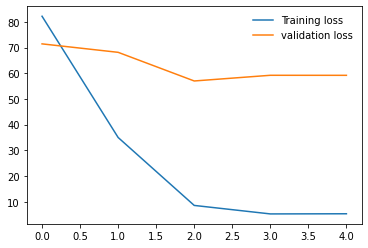

In [ ]:
from matplotlib import pyplot as plt

plt.plot(train_loss_data, label="Training loss")
plt.plot(valid_loss_data, label="validation loss")
plt.legend(frameon=False)

In [ ]:
from google.colab import output
output.enable_custom_widget_manager()

In [ ]:
from google.colab import output
output.disable_custom_widget_manager()

In [ ]:
model2.load_state_dict(torch.load("/content/drive/MyDrive/Colab Notebooks/Dataset/news_model2.pth", map_location = device))

<All keys matched successfully>

In [ ]:
all_preds = []
all_labels = []

for batch in test_dataloader:
    text, labels = batch
    inputs = tokenizer.batch_encode_plus(
        text, **tokenizer_config
    )
    input_ids = inputs['input_ids'].to(device)
    token_type_ids = inputs['token_type_ids'].to(device)
    attention_mask = inputs['attention_mask'].to(device)
    labels = labels.to(device)

    # move things to model
    output = model2(token_type_ids=token_type_ids, input_ids=input_ids, attention_mask=attention_mask)
    preds = output.detach().cpu().numpy()
    preds = np.argmax(preds, axis = 1)
    all_preds.extend(preds)
    all_labels.extend(labels.cpu().numpy())

In [ ]:
from sklearn.metrics import classification_report

# preds = np.argmax(preds, axis = 1)
print(classification_report(all_labels, all_preds))

              precision    recall  f1-score   support

           0       0.88      0.78      0.82         9
           1       0.78      0.88      0.82         8

    accuracy                           0.82        17
   macro avg       0.83      0.83      0.82        17
weighted avg       0.83      0.82      0.82        17



In [ ]:
print(model2.fc1.weight.data)

tensor([[ 0.0216, -0.0059,  0.0295,  ..., -0.0273, -0.0137,  0.0203],
        [ 0.0180, -0.0060,  0.0162,  ...,  0.0107, -0.0314,  0.0291],
        [-0.0294,  0.0246,  0.0129,  ...,  0.0284,  0.0274,  0.0021],
        ...,
        [-0.0011, -0.0253,  0.0313,  ...,  0.0049, -0.0118, -0.0299],
        [-0.0123,  0.0085, -0.0217,  ...,  0.0037, -0.0191,  0.0227],
        [-0.0236,  0.0299, -0.0263,  ...,  0.0060,  0.0161, -0.0015]],
       device='cuda:0')


In [ ]:
cf_matrix = confusion_matrix(all_labels, all_preds)  

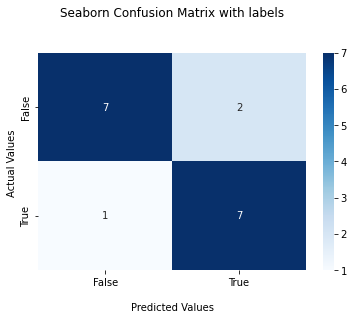

In [ ]:
import seaborn as sns

ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues')

ax.set_title('Seaborn Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

## Ticket labels - List must be in alphabetical order
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])

## Display the visualization of the Confusion Matrix.
plt.show()

In [ ]:
from sklearn.metrics import precision_score,recall_score,f1_score,accuracy_score
test_accuracy13 = accuracy_score(all_labels, all_preds)
print('Accuracy: %.3f' % test_accuracy13)
precision13 = precision_score(all_labels, all_preds, average='macro')
print('Precision: %.3f' % precision13)
recall13 = recall_score(all_labels, all_preds, average='macro')
print('Recall: %.3f' % recall13)
score13 = f1_score(all_labels, all_preds, average='macro')
print('F-Measure: %.3f' % score13)

Accuracy: 0.824
Precision: 0.826
Recall: 0.826
F-Measure: 0.824


# For Looping

In [ ]:
if precision13 >= precision and recall13 >= recall and score13 >= score :
  torch.save(model2.state_dict(), "/content/drive/MyDrive/Colab Notebooks/Dataset/news_model1.pth")
  precision = precision13
  recall = recall13
  score = score13
  model.fc1.weight.data =model2.fc1.weight.data.clone()
  model.fc1.bias.data =model2.fc1.bias.data.clone()
  model.fc2.weight.data =model2.fc2.weight.data.clone()
  model.fc2.bias.data =model2.fc2.bias.data.clone()

# Graphs

In [ ]:
training_acc_graph = [training_acc2,training_acc3,training_acc4,training_acc5,training_acc6,training_acc7,training_acc8,training_acc9,training_acc10,training_acc11,training_acc12,training_acc13]

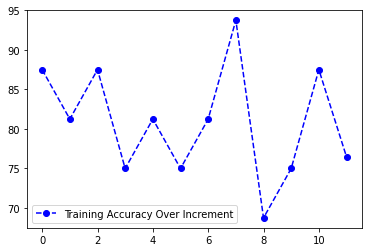

In [ ]:
plt.plot(training_acc_graph,linestyle='--', marker='o', color='b', label="Training Accuracy Over Increment")
plt.legend()

In [ ]:
testing_acc_graph = [test_accuracy2,test_accuracy3,test_accuracy4,test_accuracy5,test_accuracy6,test_accuracy7,test_accuracy8,test_accuracy9,test_accuracy10,test_accuracy11,test_accuracy12,test_accuracy13]

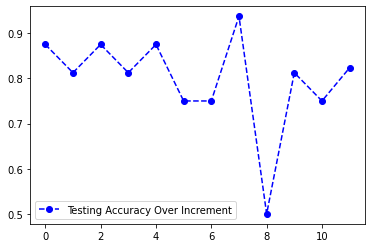

In [ ]:
plt.plot(testing_acc_graph,linestyle='--', marker='o', color='b', label="Testing Accuracy Over Increment")
plt.legend()

In [ ]:
prec_graph = [precision2,precision3,precision4,precision5,precision6,precision7,precision8,precision9,precision10,precision11,precision12,precision13]

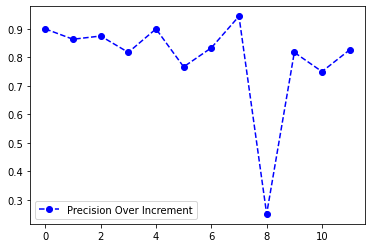

In [ ]:
plt.plot(prec_graph,linestyle='--', marker='o', color='b', label="Precision Over Increment")
plt.legend()

In [ ]:
recall_graph = [recall2,recall3,recall4,recall5,recall6,recall7,recall8,recall9,recall10,recall11,recall12,recall13]

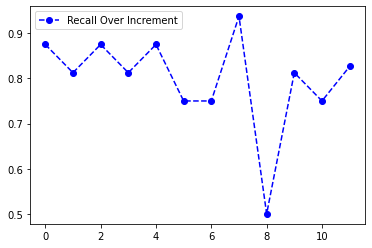

In [ ]:
plt.plot(recall_graph,linestyle='--', marker='o', color='b', label="Recall Over Increment")
plt.legend()

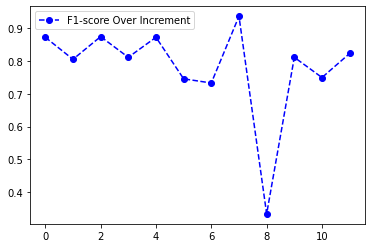

In [ ]:
f1 = [score2,score3,score4,score5,score6,score7,score8,score9,score10,score11,score12,score13]
plt.plot(f1,linestyle='--', marker='o', color='b', label="F1-score Over Increment")
plt.legend()